# Title: CA-2-AgriProject
* The project must be explored programmatically, this means that you must implement suitable Python tools (code and/or libraries) to complete the analysis required. All of this is to be implemented in a Jupyter Notebook.[0-50]
* The project documentation must include sound justifications and explanation of your code choices. (code quality standards should also be applied) [0-50]


## Install packages

In [6]:
""" %pip install pandas 
%pip install numpy  
%pip install ipywidgets  
%pip install matplotlib 
%pip install seaborn  
%pip install sklearn 
%pip install pyarrow 
# for web scraping
%pip install beautifuklsoup4 
# for web scraping 
%pip install requests
 # for pdf scraping
%pip install PyPDF2    
%pip install wordcloud 

# not sure if this is needed
%pip install pandas-profiling 
%pip install pywedge
# for sentiment analysis
%pip install vaderSentiment  """



' %pip install pandas \n%pip install numpy  \n%pip install ipywidgets  \n%pip install matplotlib \n%pip install seaborn  \n%pip install sklearn \n%pip install pyarrow \n# for web scraping\n%pip install beautifuklsoup4 \n# for web scraping \n%pip install requests\n # for pdf scraping\n%pip install PyPDF2    \n%pip install wordcloud \n\n# not sure if this is needed\n%pip install pandas-profiling \n%pip install pywedge\n# for sentiment analysis\n%pip install vaderSentiment  '

## Import packages

In [139]:
%matplotlib inline
from urllib import request as rq
import pandas as pd
import os
import pyarrow as pa # this is needed for the parquet file
import numpy as np
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, VBox
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from statsmodels.tools.eval_measures import mse, rmse
from bs4 import BeautifulSoup # for web scraping
import requests # for web scraping
import PyPDF2 # for pdf scraping
from wordcloud import WordCloud   # for word cloud
from wordcloud import STOPWORDS   # for word cloud
from wordcloud import ImageColorGenerator
import re   # for regular expression
import tkinter as tk # for GUI
from PIL import Image, ImageTk # for GUI
import csv # for csv file writing  
from pandas_profiling import ProfileReport # this is of limited use for this project
import pywedge as pw # this is a new package for data analysis
## sentiment analysis ref: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/?ref=lbp
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Set up functions

In [8]:
# Begin -- Functions to handle the reading of different internet file types

## Function to run the various search page on the IFA site
def searchIFA(searchTerm, pageNumber, header):
    
    if pageNumber == 1:
        url = 'https://www.ifa.ie/?s=' + searchTerm
    else:
        url = 'https://www.ifa.ie/page/' + str(pageNumber) + '/?s=' + searchTerm 
    r =requests.get(url, headers = header)
    soup = BeautifulSoup(r.content)
    return soup

## Function to find the links in the search results
def load_links(soup):
    #print(soup.prettify()) # output the html to a file to see what the structure is like determine that the class is ""col-sm-12 offset-md-2 col-md-10 col-lg-8 offset-lg-2 col-lg-8"" 
    # not needed in the final code, but useful for debugging
    Links = {}
    search_Results = soup.find_all("div", {"class": "col-sm-12 offset-md-2 col-md-10 col-lg-8 offset-lg-2 col-lg-8"})
    type(search_Results) # bs4.element.ResultSet is actually a list of the elements that match the search criteria
    # loop through the pages and extract the links to the articles
    for element in search_Results:
        destFilename = element.find('h3').get_text()
        # tidy the filename and remove / chatracers
        destFilename = destFilename.replace('/', '_')
        url = element.find('a').get('href')
        Links[destFilename] = url
    return Links

# Function to save the html pages as text files    
def resultText(url, destFilename, header):   # save the html pages as text files
    r =requests.get(url, headers = header)
    soup = BeautifulSoup(r.content)
    pageContent = soup.find_all("div", {"class": "single-content"})
    pageTitle = soup.find('h1', {"class": "entry-title"}).get_text()
    try:
        pageDate = soup.find('time', {"class": "entry-date"}).get_text()
        # get last 4 charaters of the date
        yr = pageDate[-4:]
        destFilename = destFilename + '_' + yr
        for element in pageContent:
            text = pageDate + '  ' +element.get_text()
            txtFile = open(destFilename + '.txt', 'w', encoding="utf-8")
            txtFile.writelines(text)
    except:
        print('No date found')

def saveResults(soup):
    # find the number of pages returned by the search

    nav_results = soup.find_all("div", {"class": "nav-links"})
    nav_results = nav_results[0].find_all('a')

    for element in nav_results:
        if element.getText() == 'Next':
            break
        max_page = element.getText()
        max_page = int(max_page)
    destDir = './Data/Raw/IFA/'
    # loop through the pages and extract the links
    for page in range(1, max_page + 1):
        #print(page)
        soup = searchIFA(searchTerm = 'silage', pageNumber = page, header = h)
        searchLinks = load_links(soup = soup)
        # now that I have the url, I can use beautiful soup to extract the text from the article
        for item in searchLinks:
            destItem = destDir + item
            resultText(url = searchLinks[item], destFilename = destItem, header=h)

## Function to download the data files from the EU website
def getEUData(y):
    # the range of weeks is every 6 weeks
    wk = range(1,53,6)
    wks = ''
    for w in wk:
        wks = wks + str(w) + ','
    # build the url for the api call
    product = ['beef', 'pigmeat', 'cereal']   
    y = str(y)
    for p in product:
        #print(p)
        url = 'https://www.ec.europa.eu/agrifood/api/' + p + '/prices?years=' + y + '&weeks=' + wks + '&beginDate=01/01/' + y + '&endDate=31/12/' + y
        #print(url)
        try:
            df = requests.get(url)
            df = df.json()
            df = pd.DataFrame(df)
            df.to_csv('./Data/Raw/EC/' + p + '_' + y + '.csv', index=False)
        except:
            print('most likely cereals error')
            pass

## Function to rewrite a text file to the file with year in the file name 
def rewriteFile(inFilename):
    inFile = open(inFilename, 'r', encoding="utf-8")
    text = inFile.read()
    yrNum = re.findall(r'\d{2}', inFilename)
    yrNum = str(yrNum[0]) # make sure that this is a string as I want to concatenate it
    outFilename = inFilename.replace(yrNum + '-A.txt', '19' + yrNum + '.txt')
    outFile = open(outFilename, 'a', encoding="utf-8")
    outFile.writelines(text) 
    outFile.close()
    inFile.close()
    os.remove(inFilename)    


# End -- Functions to handle the reading of different internet file types    

# Begin -- Data exploration fuctions

# Shapiro-Wilk test Function
def shapiro_test(x):
    p_val = stats.shapiro(x)[1]
    status = 'passed'
    color = 'blue'
    if p_val < 0.05:
        status = 'failed'
        color = 'red'
    return status, color, p_val

## Custom Scatter Plot Function
def custom_scatterplot(df1, col_x='', col_y=''):
    xcol = str(col_x)
    ycol = str(col_y)
    f = plt.figure()
    f, ax = plt.subplots(figsize=(11.5, 11.5))
    sns.regplot(df1, x = df1[col_x] , y = df1[col_y], fit_reg=True, ax=ax, scatter_kws={'alpha':0.5});
    title = 'Price of ' + ycol + ' vs. ' + xcol
    f.suptitle(title, fontsize=16)
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    
    plt.savefig('./Images/Img_scatter' + xcol + '_vs_' + ycol + '.svg')
    
    
## Custom Bar Plot Function    
def custom_barplot(df1, col1=''):
    if len(df1[col1]) > 5000: # added this to the function because of warnings about the size of data being used with shapiro test
            sampleSize = 5000
    else:
        sampleSize = len(df1[col1])
    df1 = df1.sample(sampleSize) #shapiro test is unreliable over 5000 https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test and performance reasons
    f, ax = plt.subplots(2,2, figsize=(15, 12))
    ax = ax.reshape(-1)
    df1[col1].plot(ax=ax[0], kind='hist')
    ax[0].set_title('Histogram of {}'.format(col1))
    df1[col1].plot(ax=ax[1], kind='kde')
    ax[1].set_title('Density Plot of {}'.format(col1))
    ax3 = plt.subplot(223)
    stats.probplot(df1[col1], plot=plt)
    ax[2].set_title('QQ Plot of {}'.format(col1))
    df1[col1].plot(ax=ax[3], kind='box')
    ax[3].set_title('Box Plot of {}'.format(col1))
    status, color, p_val = shapiro_test(df1[col1]) 
    f.suptitle('Normality test for {} {} (p_value = {})'.format(col1, status, p_val), color=color, fontsize=12)

## Custom function to find missing values
def num_missing(x):
    return len(x.index)-x.count()

## Custom function to find number of unique values
def num_unique(x):
    return len(np.unique(x))

## create a function to profile the data frame
def prfile_df(df):
    profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
    profile.to_widgets()

# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    print("Overall sentiment dictionary is : ", sentiment_dict)
    #print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    #print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    #print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
    #print("Sentence Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05 :
       print("Negative")
 
    else :
        print("Neutral")
    
    return sentiment_dict['compound']


# End -- Data exploration fuctions

# Begin -- Functions to handle the loading the data frame




## Functions to load data frame from csv files
def load_Files(direc, files):
    for f in files:
        yield pd.read_csv(direc + f,  delimiter=',', header=0, parse_dates=True, low_memory=True)





# Text data visuilisation functions
## define function to load image for the tkinter GUI
def load_image(year):
    # load image
    load = Image.open("./Images/" + year + ".png")
    # resize image
    try:
        load = load.resize((1000, 1000), Image.ANTIALIAS)
        # create image
        render = ImageTk.PhotoImage(load)
        # create label
        label = tk.Label(image=render)
        label.image = render
        label.place(x=100, y=100)
        #label.pack()
    except:
        pass




# image settings for the notebook
%matplotlib inline
font={'family':'normal','weight':'normal','size':8}
matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('axes', titlesize=10)
sns.set_style('whitegrid')

## Ensure that the folder structure is present in the workspace

In [145]:
if os.path.exists('./Data'):
    print('Data folder exists')
else:
    os.makedirs('./Data/Raw/IGA/')
    os.makedirs('./Data/Raw/IFA/')
    os.makedirs('./Data/Raw/EC/')
    os.makedirs('./Data/Final/')
if os.path.exists('./Images/'):
    print('Images folder exists')
else:
    os.makedirs('./Images/')

# set the IGA variable 
IGA = False

Data folder exists
Images folder exists


# Examining the Relationship Between Silage Price, Quality, and the Price of Animals

### Questions

+ Can python read PDF for sentiment anaylysis?
  + the answer to this is that yes Python has various packages that can extract text from pdf files, but none are particularly good or easy to use.
+ Are free range pigs more profitable than indoor pigs?
+ How does silage quality affect animal prices?
  +  Further to the above how does the price of animal feeds affect the price of animals? 
    + but how do I incorporate sentiment analysis in to this question?


## Abstract

The aim of this project is to examine the relationship between silage and fodder prices and the price of animals, both as live animals being sold into the food chain. The project will also examine the relationship between the quality of silage and the price of animals, and determine if there is a relationship between the quality of silage and the price of animal feed.

Silage is a type of feed that is made by fermenting and preserving green forage crops, such as grass or maize, in a manner that allows it to be stored and fed to livestock over a long period of time. The quality of silage can be affected by several factors, including the type of forage that is used, the method of fermentation and preservation, and the storage conditions.

The price of animals, whether as live animals or as a food product, can be affected by a variety of factors, including the demand for the animals and the supply of the animals. The quality of the feed that the animals are given can also affect their health and growth, which in turn can affect their price. This project will examine historical data from the https://www.irishgrassland.ie/journals/ site to determine if there is a relationship between the quality of silage and the price of animals.



## 1. Introduction

### Text Data gathering and cleaning and initial display

#### Download from the internet 

In [146]:
# Get the data from the project
# Web scraping from https://proxyway.com/guides/web-scraping-with-python#:~:text=Steps%20to%20Build%20a%20Python%20Web%20Scraper%201,parameters.%20...%203%20Step%203%3A%20Write%20the%20Script
# setting variable to stop going to IGA 
if IGA == True:
    url = "https://www.irishgrassland.ie/journals/"
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    soup = soup.find('table')
    soup = soup.find_all('a')

    # download the pdfs from Irish Grassland Journal and save them in the Raw folder
    # parse the url for the file name
    destDir = './Data/Raw/IGA/'
    for element in soup:
        url = element.get('href')
        end = url.rfind('_')
        if end > 0 : # set this condition as some of the links do not have the underscore in the file name. And these pdfs do not seem to be relevant to the project
            start = end - 4
            destFilename = destDir + 'Irish Grassland and Animal Production Association Journal_' + url[start:end] + '.pdf'
            rq.urlretrieve(url, destFilename)  

In [147]:
# extract the text from the pdfs and save them raw folder
# reference https://www.geeksforgeeks.org/working-with-pdf-files-in-python/
if IGA == True:
    destDir = './Data/Raw/IGA/'
    files = os.listdir(destDir)
    files = filter(lambda f: f.endswith(('.pdf','.PDF')), files)

    for f in files:
        pdfFileObj = open(destDir + f, 'rb')
        pdfReader = PyPDF2.PdfReader(pdfFileObj)
        num_pages = len(pdfReader.pages)
        count = 0
        text = ""
        txtFilename = destDir + f.replace('.pdf', '.txt')
        
        while count < num_pages:
            pageObj = pdfReader.pages[count]
            count +=1
            text += pageObj.extract_text()
    
        txtFile = open(txtFilename, 'w', encoding="utf-8")
        txtFile.writelines(text) 
        txtFile.close()



In [148]:
# Now I need to handle the 4 files with A in the filename
if IGA == True:
    destDir = './Data/Raw/IGA/'
    textFiles  = os.listdir(destDir)
    textFiles = filter(lambda f: f.endswith(('A.txt')), textFiles)
    for f in textFiles:
        rewriteFile(destDir + f)


In [10]:
# download the various articles that show in this search https://www.ifa.ie/?s=silage
# There are 8 pages of results for this search, so I have to loop through the pages and extract the links pages are structured as https://www.ifa.ie/page/2/?s=silage

# header code re engineered from https://stackoverflow.com/questions/41946166/requests-get-returns-403-while-the-same-url-works-in-browser
# only want to declare once in the code
h = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'} # This is chrome, you can set whatever browser you like

# intialise search and load first page to get the number of pages
soup = searchIFA(searchTerm = 'silage', pageNumber = 1, header = h)

saveResults(soup)

   

No date found


### Word Cloud Start

In [150]:
# load the text files from the Raw folder and create a dataframe
destDir = ['./Data/Raw/IGA/', './Data/Raw/IFA/']

documents = {} # create a dictionary to hold the text
years = []
for d in destDir:
    files = os.listdir(d)
    files = filter(lambda f: f.endswith(('.txt')), files)
    # Load the text data from the text documents
    for file in files:
        # Extract the year from the file name
        year = int(file.split("_")[-1].split(".")[0])
        # test for the existance of year and if it exists then append the text to the documents list
        if year in years:
            # if the year exists then we need to append the text to the existing text            
            #print('Duplicate year found')
            with open(d + file, "r" , encoding="utf-8") as f:
                text = f.read()
                # add the new text to the existing text
                documents[year] = documents[year] + text
        else:
            years.append(year) 
            with open(d + file, "r" , encoding="utf-8") as f:
                text = f.read()
                documents[year] = text
    

In [151]:
# order the documents by year
documents = dict(sorted(documents.items()))


#### Clean and standardise text data

In [152]:
# Pre-process the text data
for i in years:
    documents[i] = documents[i].lower() # Convert to lowercase
    documents[i] = documents[i].replace(".", "") # Remove punctuation
    documents[i] = documents[i].replace(",", "") # Remove punctuation
    documents[i] = documents[i].replace(":", "") # Remove punctuation
    documents[i] = documents[i].replace(";", "") # Remove punctuation
    documents[i] = documents[i].replace("?", "") # Remove punctuation
    documents[i] = documents[i].replace("!", "") # Remove punctuation
    documents[i] = documents[i].replace("\n", "") # Remove new line characters
    documents[i] = documents[i].replace("\t", "") # Remove tab characters
    documents[i] = documents[i].replace("\r", "") # Remove carriage return characters

In [153]:
# Write out the documents to a csv file in the final folder
finalDoc = './Data/Final/' + 'text_data.csv'
with open(finalDoc, 'w', encoding='utf-8') as f:
    writer = csv.writer(f)

    writer.writerow(['Key', 'Value'])

    for key, value in documents.items():
        writer.writerow([key, value])
f.close()
    


#### Word Cloud functions

In [154]:
# Create a word cloud for each year
# and remove default stop words 
wordClouds = {}
for i in years:
    wordClouds[i] = WordCloud(stopwords=STOPWORDS, background_color='white', width=1200, height=1000).generate(documents[i])


In [155]:
# examine the wordclouds to update the stop words  
# create a dataframe of the most frequent words wordClouds[years[i]].words_.items(
df = pd.DataFrame(columns=['Year', 'Word', 'Count'])
for i in years:
    # only looking to find stop words in the top 100 words - i don't think I need to look at all the words as i am only displaying the top 10 later/ 
    words = list(sorted(wordClouds[i].words_.items(), key=lambda x: x[1], reverse=True)[:100])
    words = [row[0] for row in words]
   
    # #print(words)
    wordCount = len(words)
    for j in range(0, wordCount):
              
        df = df.append({'Year': i, 'Word': words[j], 'Count': wordCount}, ignore_index=True)

In [156]:
df.head()

df['WordLenght'] = df.Word.str.len() # the lenght of words

df = df[df['WordLenght'] < 3] # remove words with less than 3 characters

display(df.Word, df.WordLenght) # review the words to be removed

Series([], Name: Word, dtype: object)

Series([], Name: WordLenght, dtype: int64)

In [157]:
# and remove stop words
stopWrds = STOPWORDS.update(df.Word)
stopWrds = STOPWORDS.update(['said', 'must', 'joe', 'healy', 'thomas', 'cooney']) # add additional stop words from review of the wordclouds below, the last 4 are names of people

In [158]:
# This is repeated from above but with the updated stop words, I could have created a function but I thought that it was not enough of a saving to justify the effort
wordClouds = {}
for i in years:
    wordClouds[i] = WordCloud(stopwords=stopWrds, background_color='white', width=1200, height=1000).generate(documents[i])



### Word Cloud Display

In [159]:
""" # all of this works but is outside of the notebook and seems a bit clunky
# code to create the word cloud images 
for y in years:
    # Create the word cloud
    showWordCloud(y)
# this works but is outside of hte notebook
window = tk.Tk()
window.geometry("1400x1200")
window.title("Word Cloud Slider")

# Create the slider widget
tkInt = (years[len(years) - 1] - years[0]/len(years))
slider = tk.Scale(window, from_=years[0], to=years[len(years) - 1], orient=tk.HORIZONTAL, tickinterval=tkInt, resolution=1, length=500,  command=load_image)
label = tk.Label(window, text="Word Cloud of the Year", font=("Arial", 20))

slider.pack()
label.pack()
   
# Run the tkinter event loop
window.mainloop()
 """
# this is a better implementation of how to view the word clouds
def browse_images(wordClouds):
    n = len(wordClouds.items())
    def view_image(i):
        N = 10
        # create 10 word dictionary of the word cloud
        srtWords = dict(sorted(wordClouds[years[i]].words_.items(), key=lambda x: x[1], reverse=True)[:N])
        # had to use subplots to get the word cloud to display in one row
        fig, ax = plt.subplots(figsize=(18,10), nrows=1, ncols=2)
        ax[0].imshow(wordClouds[years[i]], interpolation='bilinear')
        ax[0].set_title('Word cloud for the year ' + str(years[i]))
        ax[0].axis('off')     
        ax[1].barh(list(srtWords.keys()), list(srtWords.values()), align='edge')
        ax[1].set_title('Top ' + str(N) + ' words for the year ' + str(years[i]))
        #ax[1].axis('off')   
        plt.savefig('./Images/WordCloud_' + str(years[i]) + '_.svg')
    interact(view_image, i=(0,n-1))

browse_images(wordClouds)

interactive(children=(IntSlider(value=23, description='i', max=47), Output()), _dom_classes=('widget-interact'…

#### Initial look at the Word Cloud data
We can see by moving the slider through the years that the top 10 words found in the documentation show a change in the focus of farming concerns. For instance in 1962 silage was the second most common word, then in 1968 soil and soil nutrients are dominating the top 10 words. Then 1969 we see silage, silage making, cattle and liveweight gain all in the top ten, then in 1970 feed has taken over along with calve and calf, suggesting that the focus has shifted to rearing young animals. Through out 1970's, 1980's and up to 2000's, there is a shift of focus onto milk production as evidenced by the words: Milk, Cow, and calving, the animal food requirements were evidenced by the words: silage, grass, dry matter (a key component of silage) and barley. 
In the 1980's sheep and other ovine words start appearing, but silage and grass are still the most common words, in the year 2002, the word 'Maize' appears in the word cloud, but it does not make the top 10. however it's appearance is interesting as it is an American word for corn, and in the EU it is used as an animal feed. Through out the 2000' silage disappears from the top 10 words, and is replaced by the words: grass, maize, barley, and dry matter, but it stil appears in the word clouds suggesting that it is still a key component of animal feed.

Becasue Will and Farm show up so much there is an arguement to be made that they should be removed from the word cloud, but I will leave them in for now as they show up an interesting trend in the data; that farm succession was a key concern through out the decades and is still a concern today.

### Price Data gathering and cleaning and initial display

In [160]:
# Download beef prices from https://www.ec.europa.eu/agrifood/api/beef/prices?years=1991,2022&months=1,2,3,4,5,6,7,8,9,10,11,12&beginDate=01/01/1991&endDate=31/12/2021
# The range of years is 2009 to 2022
yr = range(2009,2022)
for y in yr:
    getEUData(y)

most likely cereals error
most likely cereals error
most likely cereals error
most likely cereals error


In [161]:
# display the data from one csv file and check for the values in the category/productname column
df = pd.read_csv('./Data/Raw/EC/pigmeat_2010.csv')
print('Pig Meat data frame is ' + str(df.shape) + ' rows and columns')
display(df.head())
display(df.pigClass.unique())
display(df.info())
#prfile_df(df)

# display the data from one csv file and check for the values in the category/productname/stageName column
df = pd.read_csv('./Data/Raw/EC/cereal_2010.csv')
print('Cereals data frame is ' + str(df.shape) + ' rows and columns')
display(df.head())
# get the unique column values from stageName column
display(df.stageName.unique())
display(df.productName.unique())
display(df.info())
#prfile_df(df)

# display the data from one csv file and check for the values in the category/productname column
df = pd.read_csv('./Data/Raw/EC/beef_2009.csv')
print('Beef Meat data frame is ' + str(df.shape) + ' rows and columns')
display(df.head())
display(df.category.unique())
display(df.info())
#prfile_df(df)

Pig Meat data frame is (702, 8) rows and columns


memberStateCode memberStateName   beginDate     endDate  weekNumber  \
0              AT         Austria  06/12/2010  12/12/2010          49   
1              AT         Austria  06/12/2010  12/12/2010          49   
2              BE         Belgium  06/12/2010  12/12/2010          49   
3              BE         Belgium  06/12/2010  12/12/2010          49   
4              BE         Belgium  06/12/2010  12/12/2010          49   

     price    unit       pigClass  
0  €140,71  100 KG  Average S + E  
1  €140,71  100 KG              E  
2  €130,70  100 KG  Average S + E  
3  €130,70  100 KG              E  
4   €34,50       P         Piglet

array(['Average S + E', 'E', 'Piglet'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   memberStateCode  702 non-null    object
 1   memberStateName  702 non-null    object
 2   beginDate        702 non-null    object
 3   endDate          702 non-null    object
 4   weekNumber       702 non-null    int64 
 5   price            702 non-null    object
 6   unit             702 non-null    object
 7   pigClass         702 non-null    object
dtypes: int64(1), object(7)
memory usage: 44.0+ KB


None

Cereals data frame is (64, 10) rows and columns


memberStateCode memberStateName   beginDate     endDate  weekNumber  \
0              BG        Bulgaria  13/12/2010  19/12/2010          25   
1              BG        Bulgaria  13/12/2010  19/12/2010          25   
2              BG        Bulgaria  13/12/2010  19/12/2010          25   
3              RO         Romania  13/12/2010  19/12/2010          25   
4              RO         Romania  13/12/2010  19/12/2010          25   

     price    unit    productName marketName  \
0  €186,62  TONNES     Feed wheat    Dobrich   
1  €196,85  TONNES  Milling wheat    Dobrich   
2  €161,06  TONNES          Maize     Pleven   
3  €173,64  TONNES          Maize    Oltenia   
4  €129,46  TONNES    Feed barley   Muntenia   

                                           stageName  
0  Departure from farm or from production area - ...  
1  Departure from farm or from production area - ...  
2  Departure from farm or from production area - ...  
3  Departure from silo - after some storage - on ...  
4  Departure from silo - after some storage - on ...

array(['Departure from farm or from production area - on truck or other transport means',
       'Departure from silo - after some storage - on truck or other transport means',
       'Free On Board - Incoterm'], dtype=object)

array(['Feed wheat', 'Milling wheat', 'Maize', 'Feed barley'],
      dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   memberStateCode  64 non-null     object
 1   memberStateName  64 non-null     object
 2   beginDate        64 non-null     object
 3   endDate          64 non-null     object
 4   weekNumber       64 non-null     int64 
 5   price            64 non-null     object
 6   unit             64 non-null     object
 7   productName      64 non-null     object
 8   marketName       64 non-null     object
 9   stageName        64 non-null     object
dtypes: int64(1), object(9)
memory usage: 5.1+ KB


None

Beef Meat data frame is (4778, 9) rows and columns


memberStateCode memberStateName   beginDate     endDate  weekNumber  \
0              AT         Austria  30/11/2009  06/12/2009          49   
1              AT         Austria  30/11/2009  06/12/2009          49   
2              AT         Austria  30/11/2009  06/12/2009          49   
3              AT         Austria  30/11/2009  06/12/2009          49   
4              AT         Austria  30/11/2009  06/12/2009          49   

     price     unit     category productCode  
0  €320.41  €/100Kg  Young bulls        A R3  
1  €317.26  €/100Kg       Steers        C U4  
2  €224.25  €/100Kg         Cows        D R4  
3  €277.54  €/100Kg      Heifers        E R2  
4  €191.55  €/100Kg         Cows        D O2

array(['Young bulls', 'Steers', 'Cows', 'Heifers', 'Bulls',
       'Adult male indicative price'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4778 entries, 0 to 4777
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   memberStateCode  4778 non-null   object
 1   memberStateName  4778 non-null   object
 2   beginDate        4778 non-null   object
 3   endDate          4778 non-null   object
 4   weekNumber       4778 non-null   int64 
 5   price            4778 non-null   object
 6   unit             4778 non-null   object
 7   category         4778 non-null   object
 8   productCode      4778 non-null   object
dtypes: int64(1), object(8)
memory usage: 336.1+ KB


None

### 2.1 Business Understanding

The project is seeking to predict meat prices based on the price of animal feed. To this we will create a dataset with 2 target variables, beef price for an 'Adult male indicative price' and the price of 'Average S + E' for pig meat, the predictor variables will be the prices of 'Feed wheat' and 'Feed barley'. There are two targets one for beef and one for pig meat, it was not possible to find prices for other fodder products such as hay, haylage or silage. The only site that I could find was https://www.clal.it and it did not have data that could be downloaded programmatically. 

The data was downloaded from https://www.ec.europa.eu/agrifood/api/ and the data was cleaned and prepared for analysis. The data was then analysed to determine if there was a relationship between the price of animal feed and the price of animals.

Below we take a look at the raw data, to see what we are working with, and to determine which columns we will use for our analysis from each set, and which columns are common to all sets. These columns are as follows: 
+ memberStateCode
+ memberStateName
+ beginDate
+ endDate
+ weekNumber
+ price

We will drop the following columns from the data sets:
+ Beef Data set 
    + memberStateName
    + unit
    + productCode
+ Cereals Data set
    + memberStateName
    + unit
    + marketName
    + stageName
+ Pig Meat Data set
    + memberStateName
    + unit



In [162]:
# data cleanup and preparation


files = os.listdir('./Data/Raw/EC/')
beef_files = filter(lambda x: x.startswith('beef'), files)
cereal_files = filter(lambda x: x.startswith('cereal'), files)
pig_files = filter(lambda x: x.startswith('pig'), files)
# because the data are slightly different structures, I have to handle them separately before joining them together
df_beef = pd.concat(load_Files('./Data/Raw/EC/', beef_files))
# filter the data to only include the columns that are required
df_beef = df_beef[df_beef['category'] == 'Adult male indicative price']
df_beef = df_beef[['memberStateCode', 'beginDate', 'endDate', 'weekNumber', 'price']]
df_beef['beginDate'] = pd.to_datetime(df_beef['beginDate'], format='%d/%m/%Y')
df_beef['endDate'] = pd.to_datetime(df_beef['endDate'], format='%d/%m/%Y')
# remove the euro sign and convert the price to a float
df_beef['price'] = df_beef['price'].replace({'\€': '', ',' : ''}, regex=True).astype(float)
df_beef = df_beef.rename(columns={'price': 'beef_price', 'category': 'productName'})

df_cereal = pd.concat(load_Files('./Data/Raw/EC/', cereal_files))
df_cereal_wheat = df_cereal[df_cereal['productName'] == 'Feed wheat']
df_cereal_wheat = df_cereal_wheat.rename(columns={'price': 'wheat_price'})
df_cereal_barley = df_cereal[df_cereal['productName'] == 'Feed barley']
df_cereal_barley = df_cereal_barley.rename(columns={'price': 'barley_price'})
# merge the wheat and barley dataframes 
df_cereal = pd.merge(df_cereal_wheat, df_cereal_barley, on=['memberStateCode', 'beginDate', 'endDate', 'weekNumber'])
df_cereal = df_cereal[['memberStateCode', 'beginDate', 'endDate', 'weekNumber', 'wheat_price', 'barley_price']]
display(df_cereal.head())

df_cereal['beginDate'] = pd.to_datetime(df_cereal['beginDate'], format='%d/%m/%Y')
df_cereal['endDate'] = pd.to_datetime(df_cereal['endDate'], format='%d/%m/%Y')
# remove the euro sign and convert the price to a float - note that the price contains a comma     
df_cereal['wheat_price'] = df_cereal['wheat_price'].replace({'\€': '', ',': '.'}, regex=True).astype(float)
df_cereal['barley_price'] = df_cereal['barley_price'].replace({'\€': '', ',': '.'}, regex=True).astype(float)

df_pig = pd.concat(load_Files('./Data/Raw/EC/', pig_files))
df_pig = df_pig[df_pig['pigClass'] == 'Average S + E']
df_pig = df_pig[['memberStateCode', 'beginDate', 'endDate', 'weekNumber', 'price']]
df_pig['beginDate'] = pd.to_datetime(df_pig['beginDate'], format='%d/%m/%Y')
df_pig['endDate'] = pd.to_datetime(df_pig['endDate'], format='%d/%m/%Y')
# remove the euro sign and convert the price to a float - note that the price contains a comma     
df_pig['price'] = df_pig['price'].replace({'\€': '', ',' : '.'}, regex=True).astype(float)
df_pig = df_pig.rename(columns={'price': 'pig_price', 'pigClass': 'productName'})



memberStateCode   beginDate     endDate  weekNumber wheat_price barley_price
0              BG  14/12/2009  20/12/2009          25      €97,15       €92,03
1              RO  14/12/2009  20/12/2009          25     €101,91       €82,95
2              RO  01/11/2010  07/11/2010          19     €177,03      €104,11
3              BG  20/09/2010  26/09/2010          13     €168,73      €150,83
4              RO  20/09/2010  26/09/2010          13     €142,91       €98,89

### Check for missing and have a brief look at the data 

The Temp_df contains the output of a pandas description function. The missing_ df contains the output of function which counts missing values in a column.

In [163]:
# join the dataframes together
df = df_beef.merge(df_cereal, how='left', on=['memberStateCode', 'weekNumber'])
df = df.merge(df_pig, how='left', on=['memberStateCode',  'weekNumber'])


temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df.style)

display(missing_df.style)

As we can see there is an issue with the dates beginDate and endDate, they do not match the weekNumber in the different data sets. This is a problem as we will need to merge the data sets on the weekNumber column.

The solution is to create year column from the beginDate column, and then drop the beginDate and endDate columns. 

We can see that there are missing values in the data set, but this time they are in the price column and year_y. This is because cereal data set does not have the same amount of data for each year, the solution is to use the cereal data as the first merge.

In [164]:
df_beef['year'] = df_beef['beginDate'].dt.year
df_beef = df_beef.drop(['beginDate', 'endDate'], axis=1)

df_cereal['year'] = df_cereal['beginDate'].dt.year
df_cereal = df_cereal.drop(['beginDate', 'endDate'], axis=1)

df_pig['year'] = df_pig['beginDate'].dt.year
df_pig = df_pig.drop(['beginDate', 'endDate'], axis=1)

Having fixed the dates we can now merge the data sets on the weekNumber column.

In [165]:
# join the dataframes together
df = df_cereal.merge(df_pig, how='left', on=['memberStateCode', 'year', 'weekNumber'])
df = df.merge(df_beef, how='left', on=['memberStateCode', 'year', 'weekNumber'])


temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df.style)

display(missing_df.style)

In [166]:
# remove the rows with missing values 
df = df.dropna()
df = df.sort_values(by=['year', 'weekNumber', 'memberStateCode'])
df = df.reset_index(drop=True)
temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df.style)

display(missing_df.style)

### 2.2 Data Understanding

#### Initial look at the data, check for missing data
Discuss in detail the process of acquiring your raw data, detailing the positive and/or negative aspects of your research and acquisition. This should include the relevance and implications of any and all licensing/permissions associated with the data. [0-15]

Data was sourced from a number of sources including the https://www.irishgrassland.ie/journals/ site, the https://www.teagasc.ie/ site, and the https://www.teagasc.ie/ site. The data was gathered from the pdf files on the sites and converted to csv files using the tabula-py package. The data was then cleaned and merged into a single dataset. The data was then analysed using the pandas and matplotlib packages.


#### Exploratory data analysis
Exploratory Data Analysis helps to identify patterns, inconsistencies, anomalies, missing data, and other attributes and issues in data sets so problems can be addressed. 

Evaluate your raw data and detail, in depth, the various attributes and issues that you find. Your evaluation should reference evidence to support your  chosen methodology and use visualizations to illustrate your findings.[0-25]


Display the shape and types of data

In [167]:
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']  # type: ignore
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType'] # type: ignore
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
display(summary_df.style) # Numerical Data

Describe the numerical data 

Use descriptive statistics and appropriate visualisations in order to summarise the dataset(s) used, and to help justify the chosen models. [0-20]


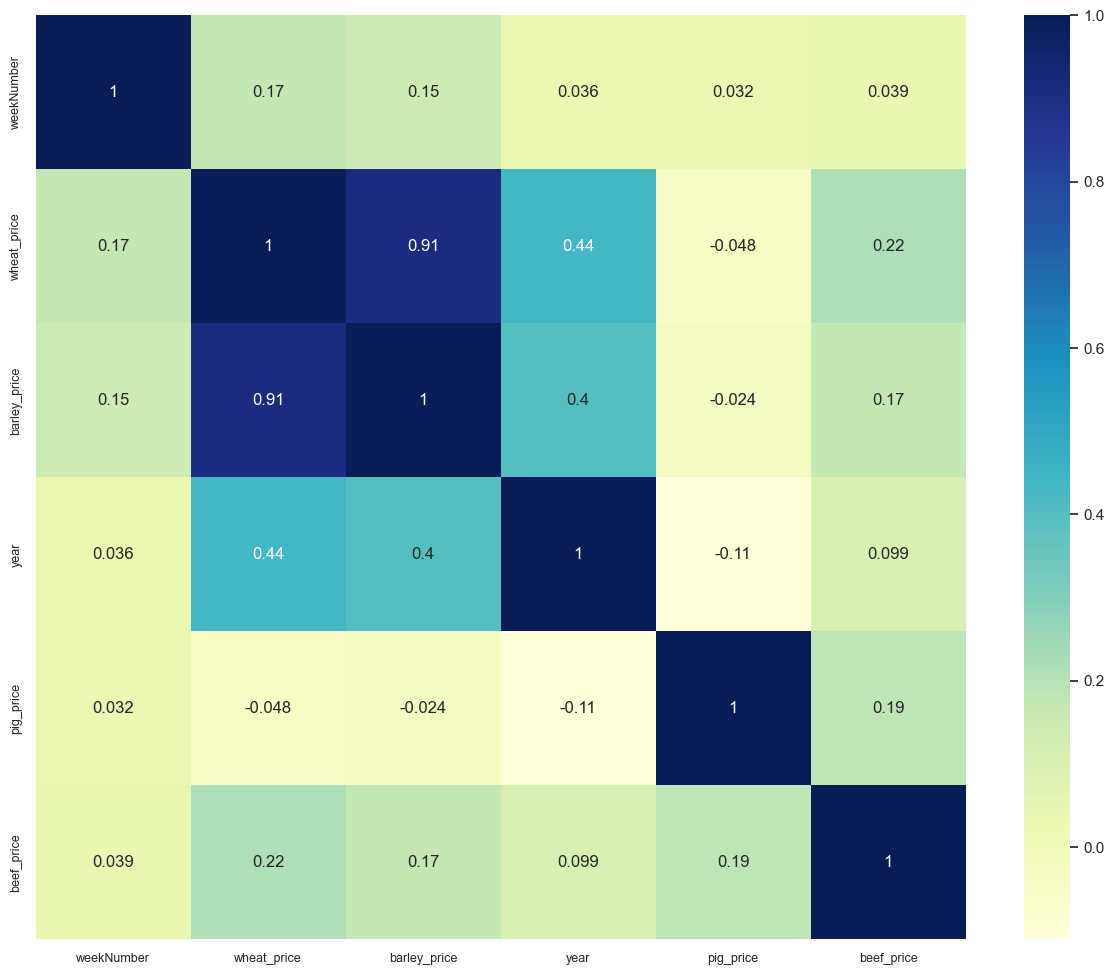

In [168]:
c_df = df.corr('pearson')
ffig, ax = plt.subplots(figsize=(15,12))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="YlGnBu", annot=True)
plt.savefig('./Images/Img_2.2_MergedCorHeatmap.svg')
plt.show()

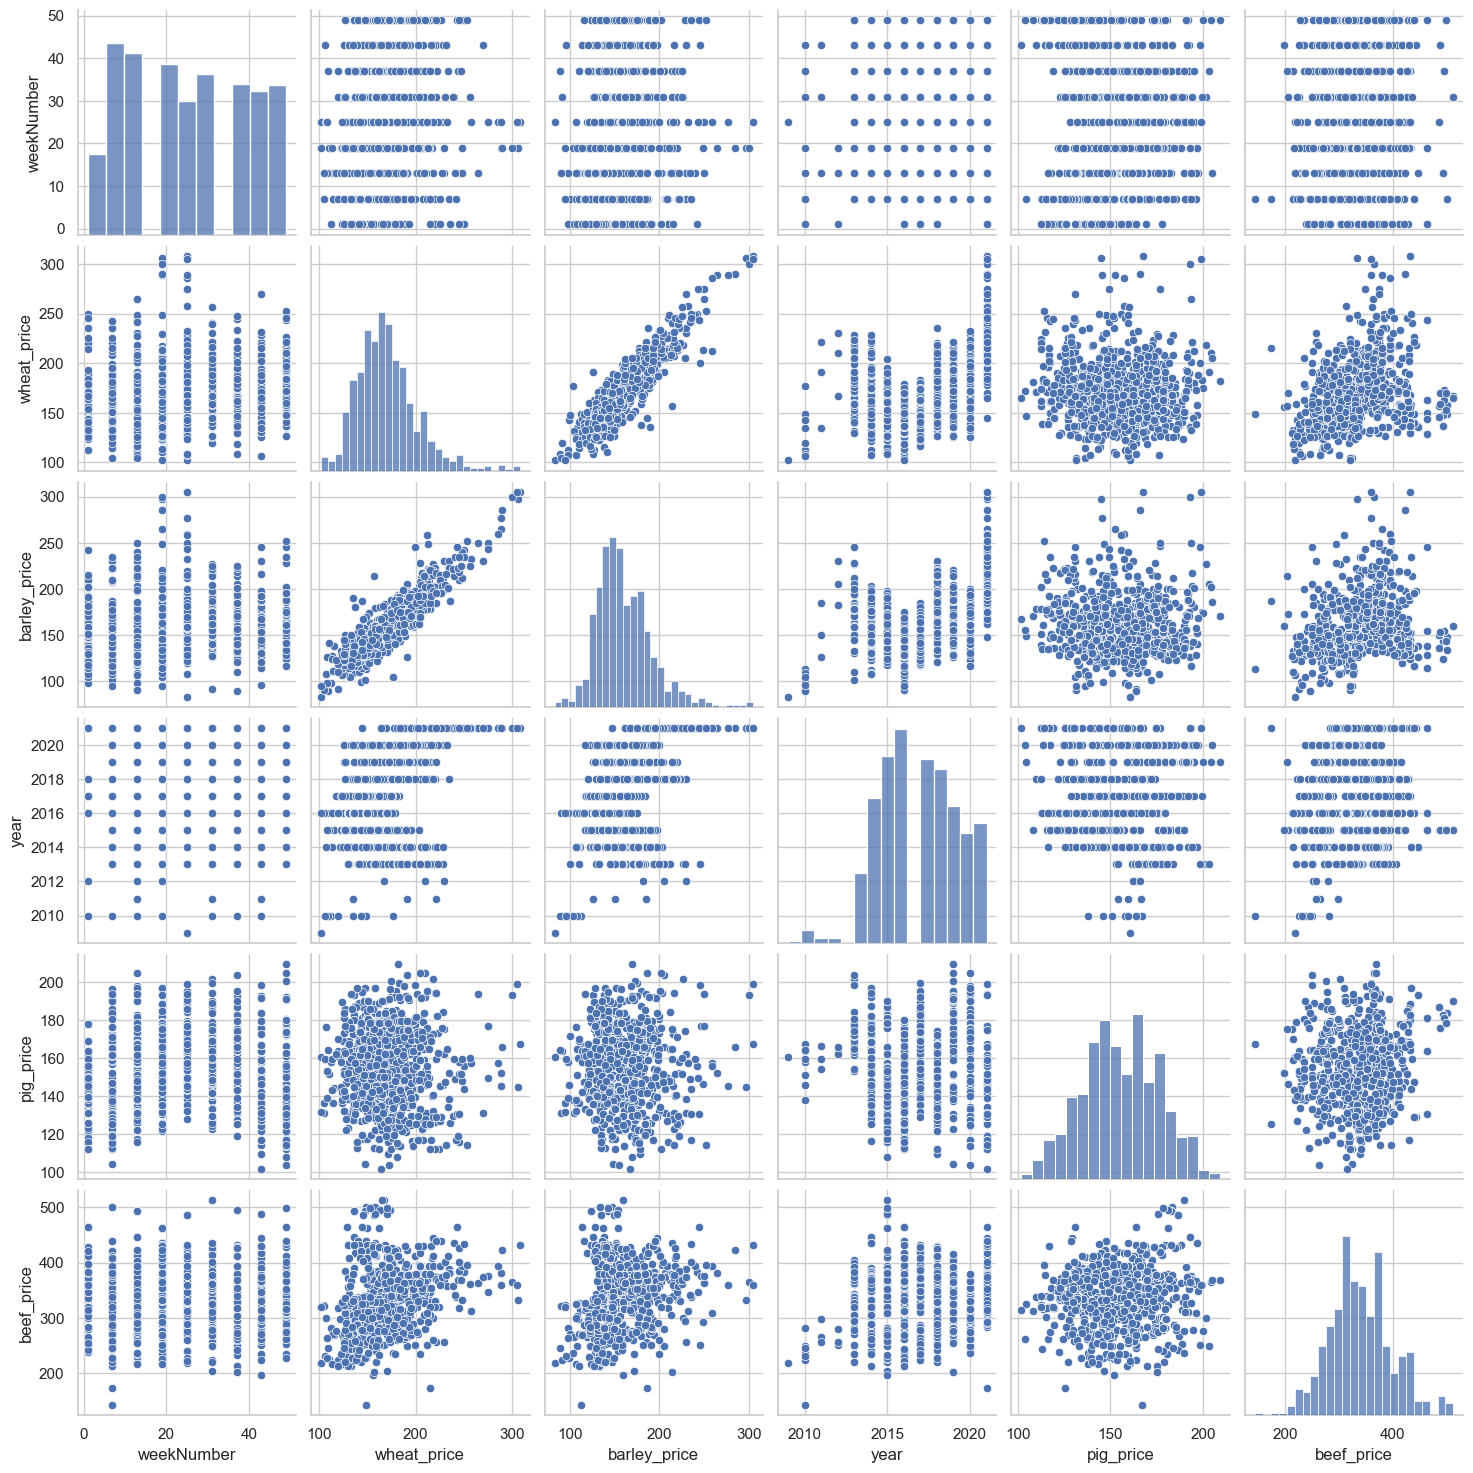

In [169]:
sns.pairplot(df);
plt.savefig('./Images/Img_2.2_pairplot.svg')


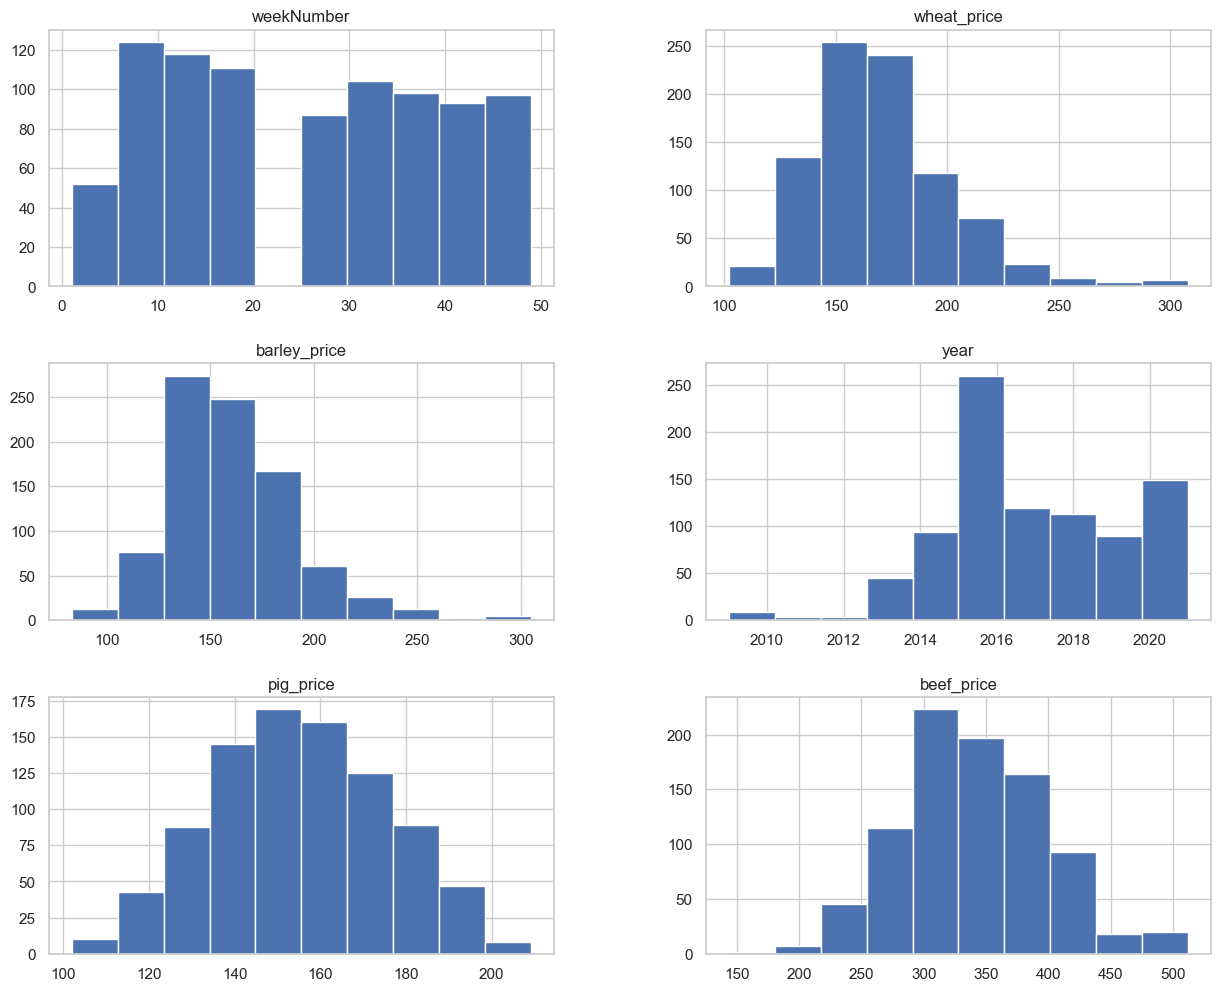

In [170]:
df.hist(figsize=(15,12));
plt.savefig('./Images/Img_2.2_price_histogram.svg')

Set the Numerical and Categorical columns

Analyse the variables in your dataset(s) and use appropriate inferential statistics to gain insights on possible population values 

(e.g., if you were working with international commerce, you could find a confidence interval for the population proportion of yearly dairy exports out of all agricultural exports). [0-20]


In [22]:
CategoricalColumns = ['memberStateCode']
NumericalColumns = ['year', 'weekNumber', 'barley_price', 'wheat_price', 'beef_price', 'pig_price']

In [172]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in CategoricalColumns:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
print(summary_df_cat.style)

Display plots from the Data set, including Histograms, pairplots, boxplots and correlation
* possibly use seaborn reg plots to check linear regression from the correlation plots 

Undertake research to find similarities between some country(s) against Ireland, and apply parametric and non-parametric inferential statistical techniques to compare them 

(e.g., t-test, analysis of variance, Wilcoxon test, chi-squared test, among others). 

You must justify your choices and verify the applicability of the tests. Hypotheses and conclusions must be clearly stated. 

You are expected to use at least 5 different inferential statistics tests. [0-40]


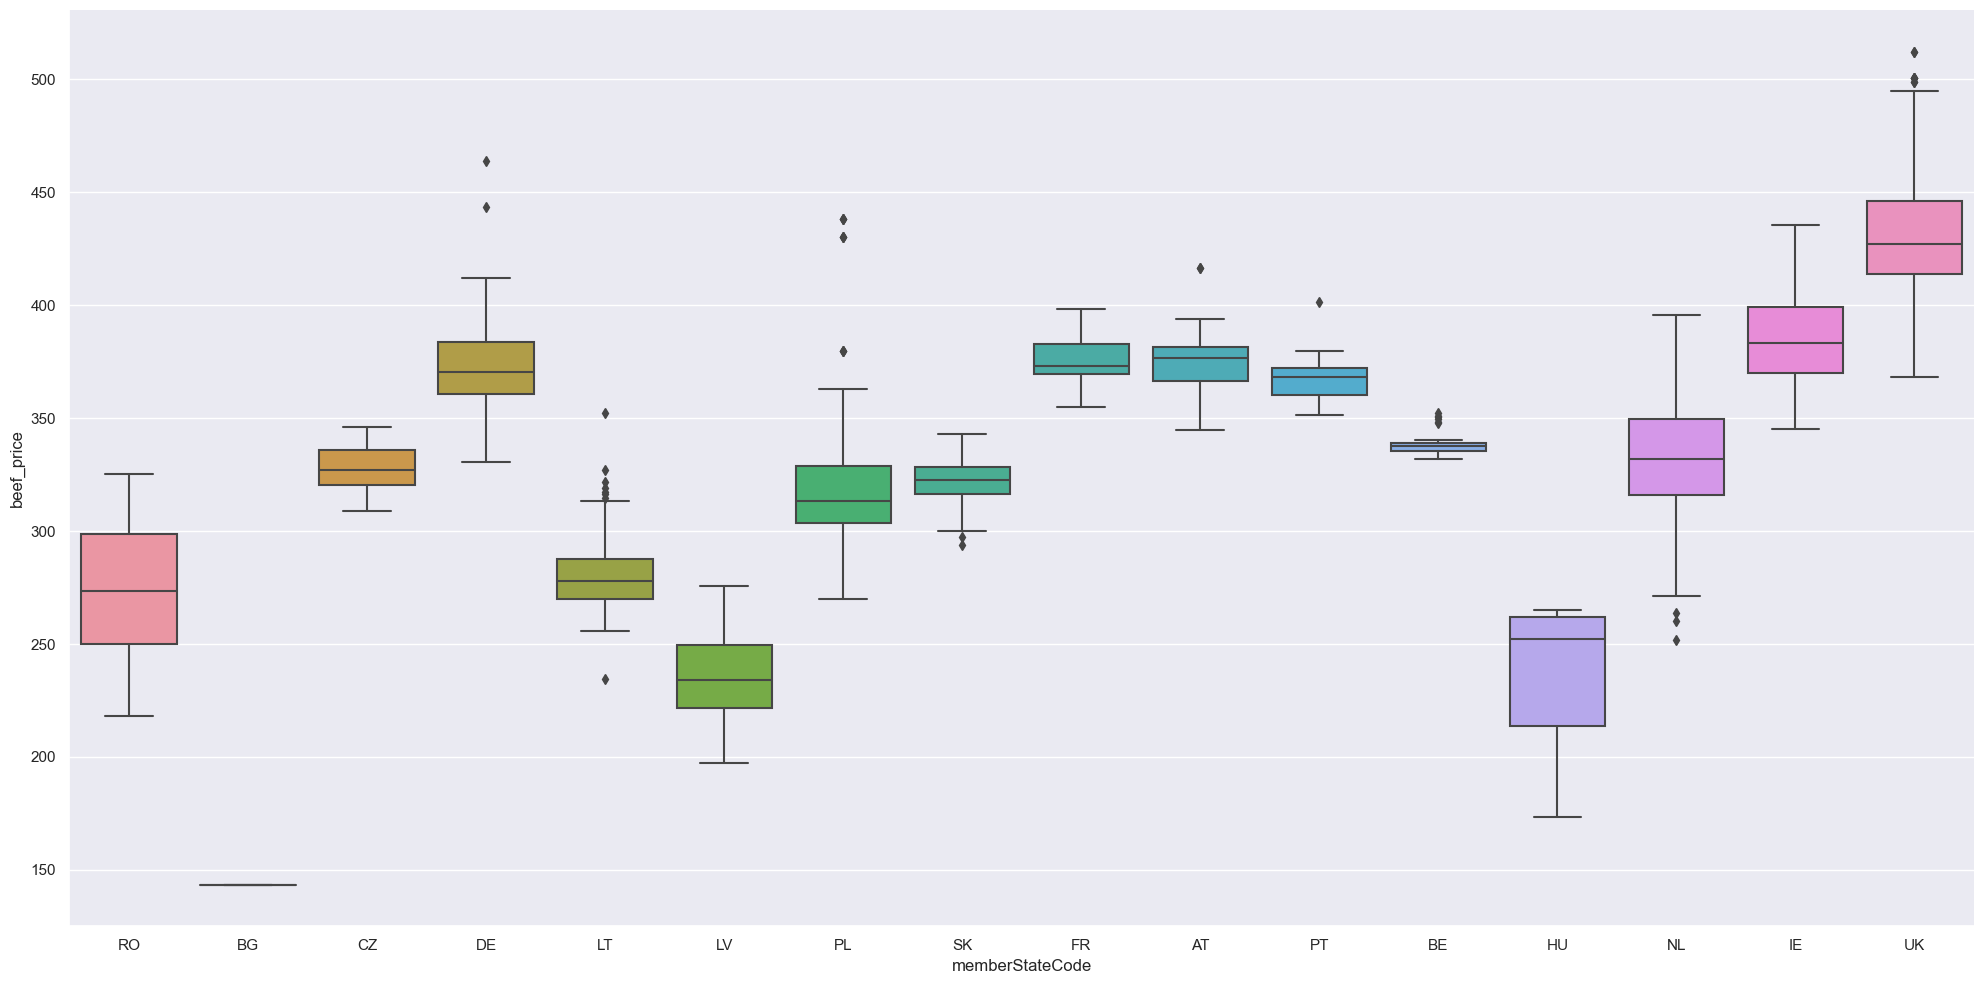

In [173]:
sns.set(color_codes=True)
sns.catplot(data=df, x='memberStateCode', y = 'beef_price' , kind='box', height=10, aspect=2);
plt.savefig('./Images/Img_2.2_price_beef_price.svg')

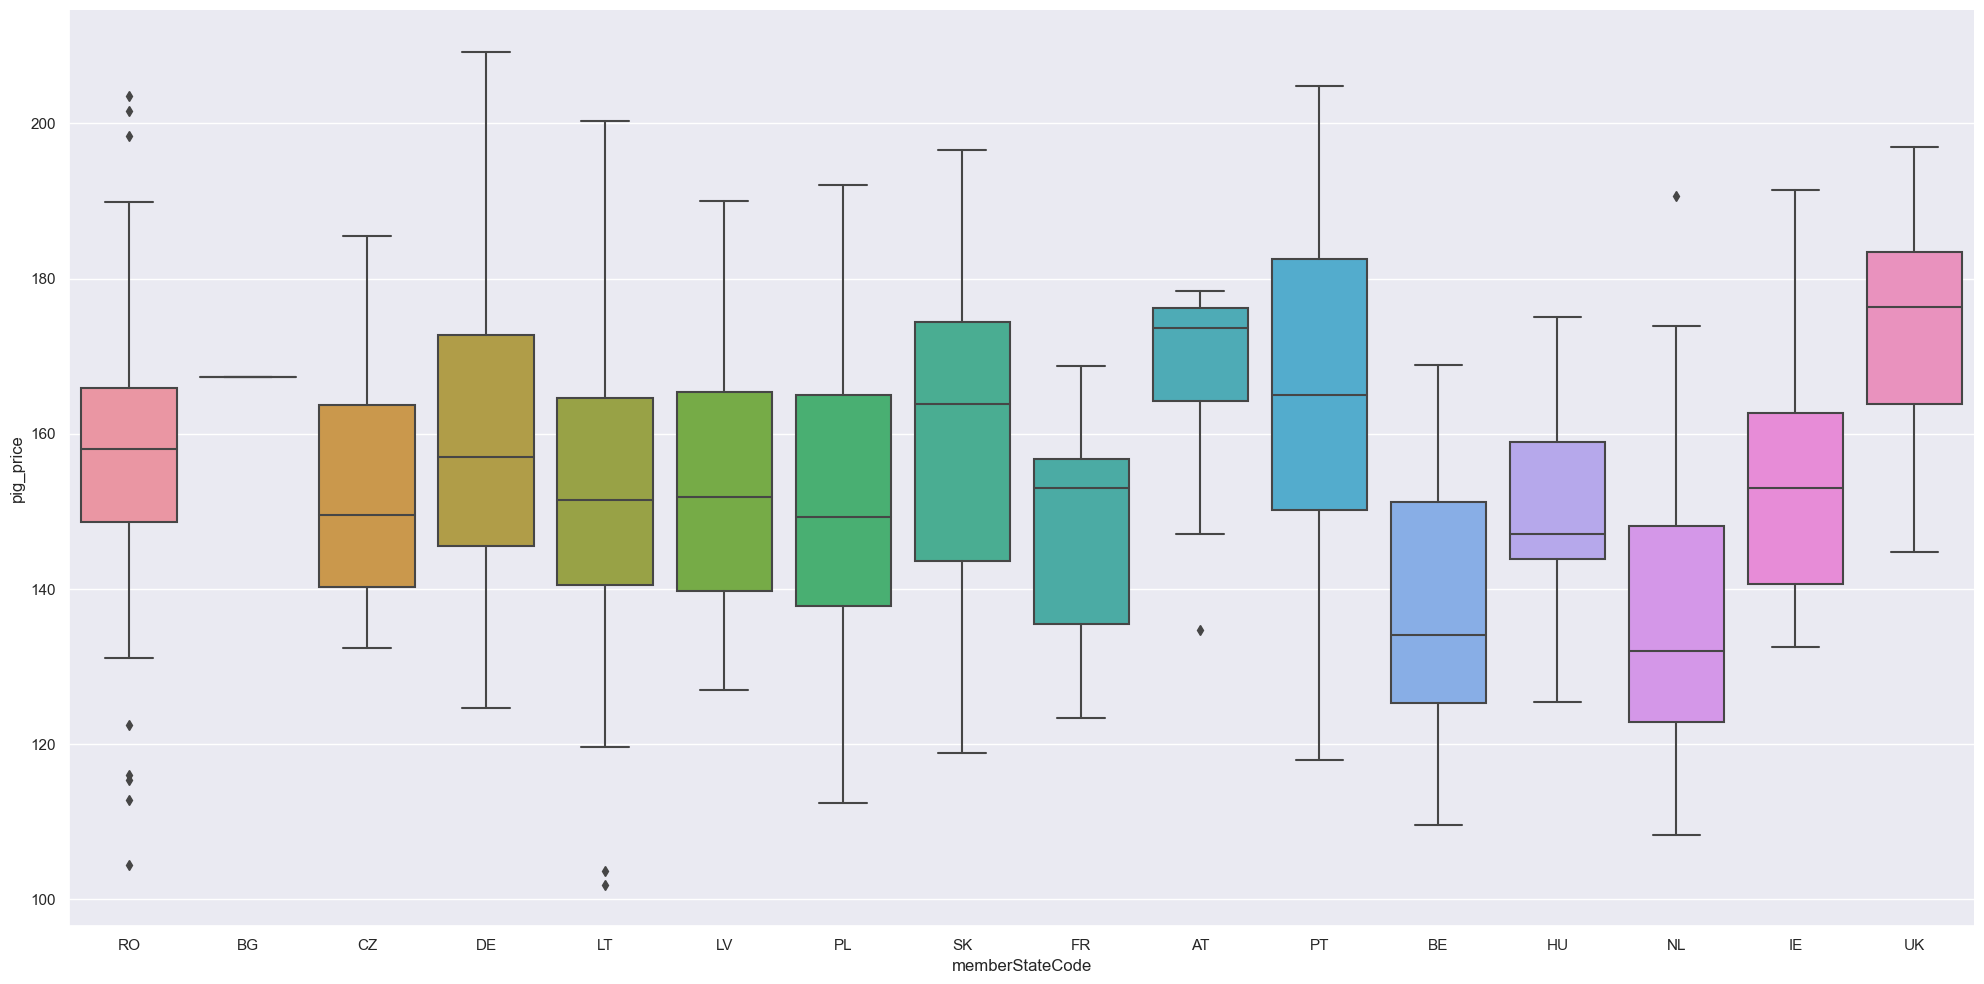

In [174]:
sns.set(color_codes=True)
sns.catplot(data=df, x='memberStateCode', y = 'pig_price' ,   kind='box', height=10, aspect=2);
plt.savefig('./Images/Img_2.2_memberstate_pig_price.svg')

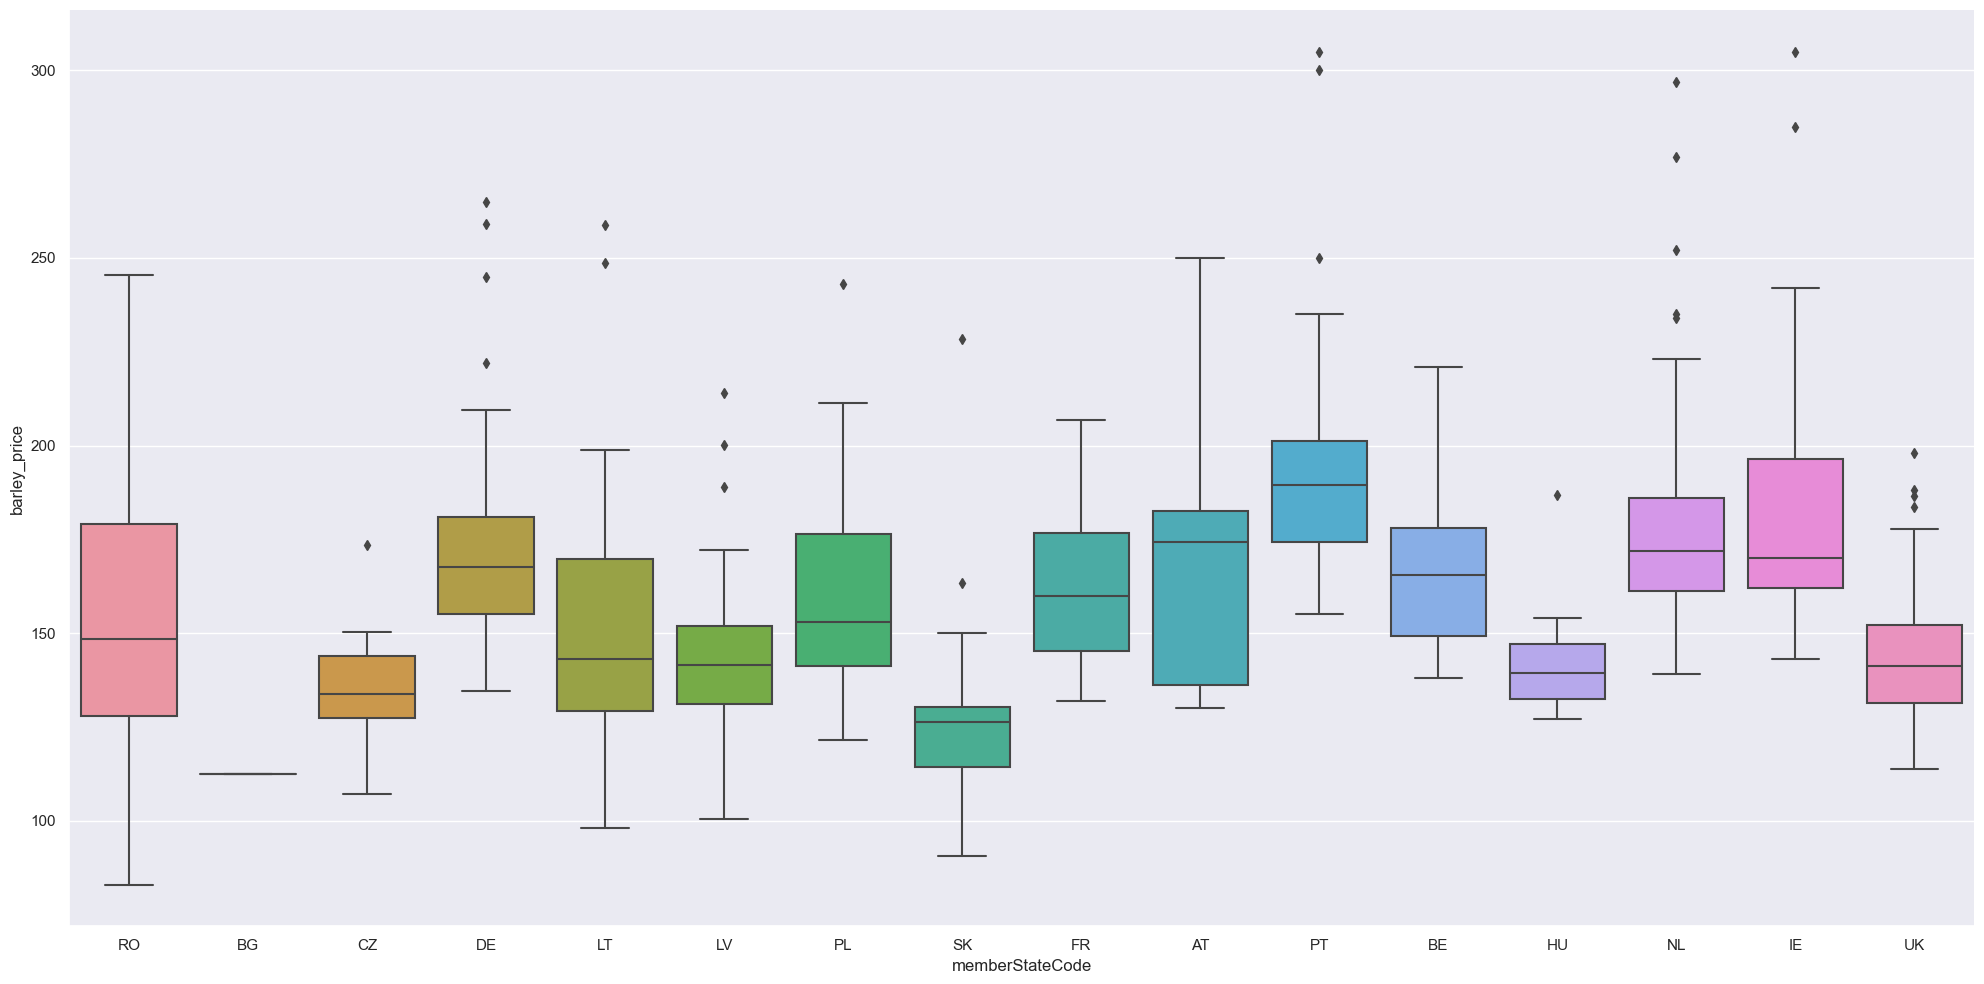

In [175]:
sns.set(color_codes=True)
sns.catplot(data=df, x='memberStateCode', y = 'barley_price' ,   kind='box', height=10, aspect=2);
plt.savefig('./Images/Img_2.2_memberStateCode_barley_price.svg')

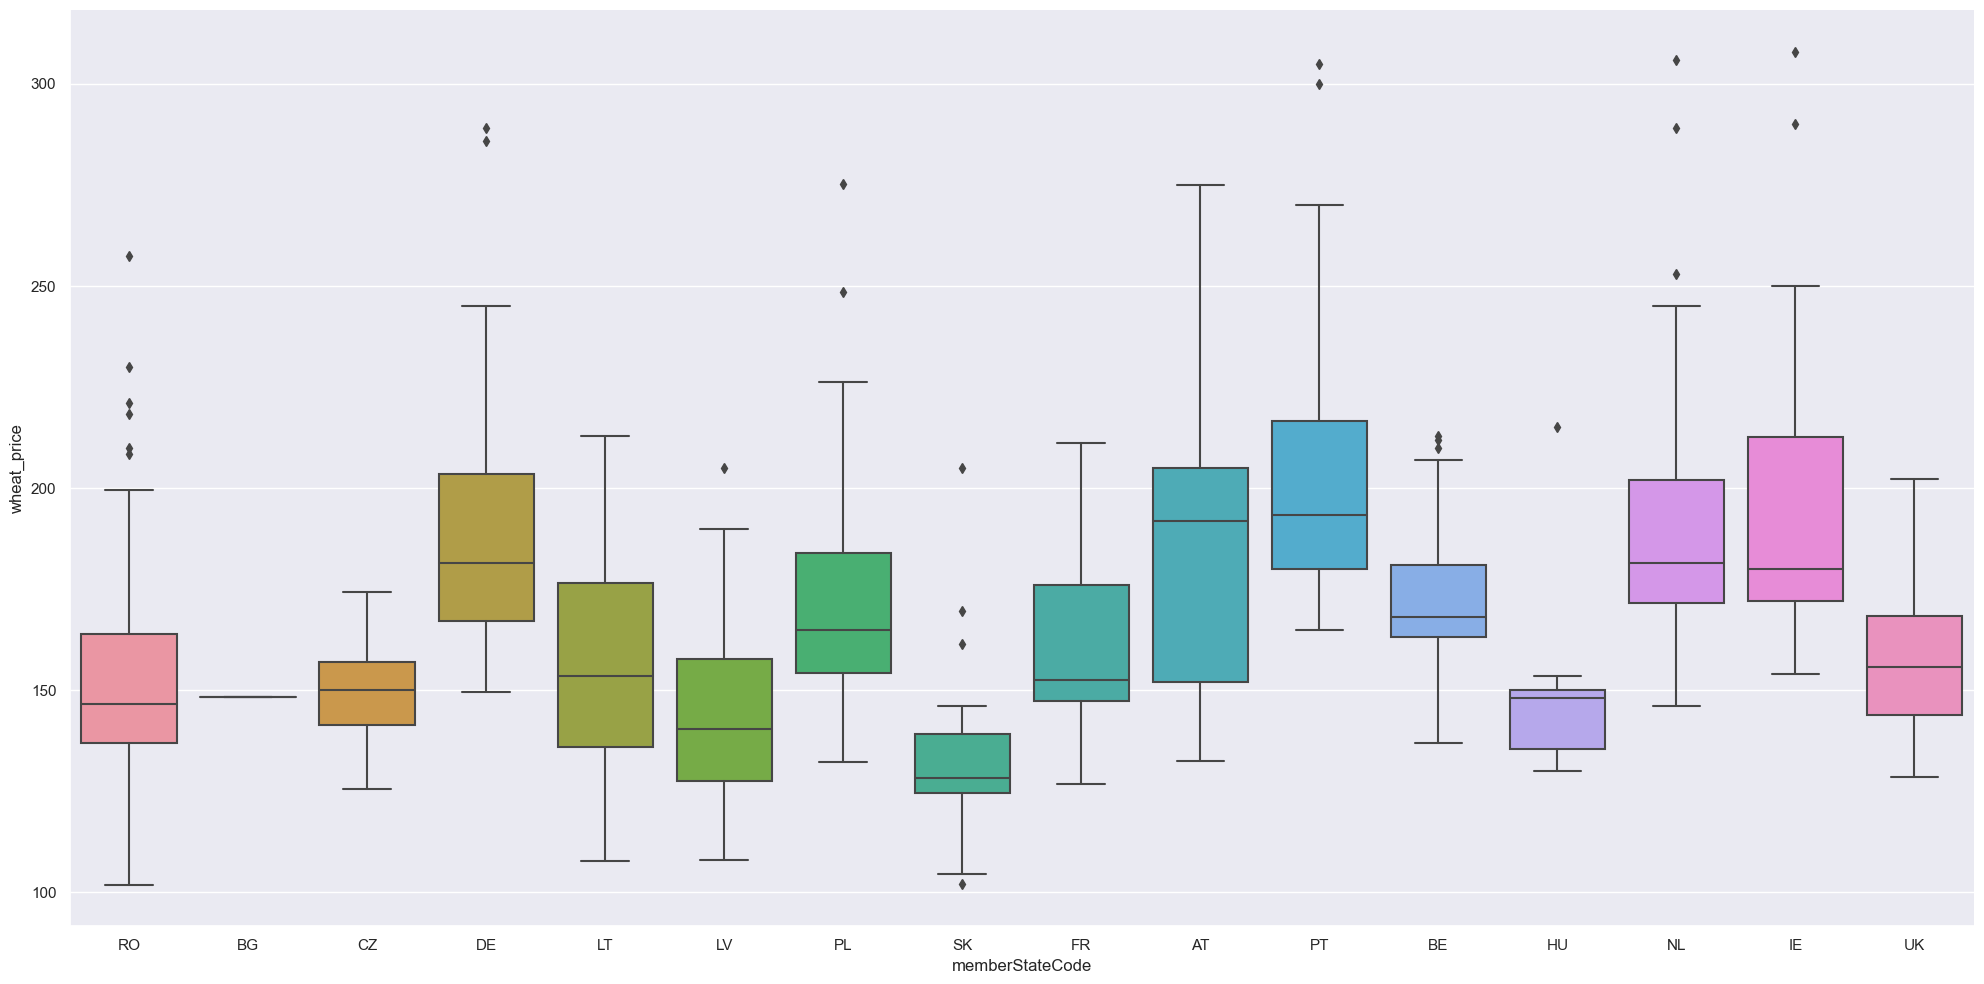

In [176]:
sns.set(color_codes=True)
sns.catplot(data=df, x='memberStateCode', y = 'wheat_price' ,   kind='box', height=10, aspect=2);
plt.savefig('./Images/Img_2.2_memberStateCode_wheat_price.svg')

Check for Outliers

Use the outcome of your analysis to deepen your research. 

Indicate the challenges you faced in the process. [0-20]

In [177]:

z_barley_price = np.abs(stats.zscore(df['barley_price']))
z_wheat_price = np.abs(stats.zscore(df['wheat_price']))
z_beef_price = np.abs(stats.zscore(df['beef_price']))
z_pig_price = np.abs(stats.zscore(df['pig_price']))
df['Zscore_barley_price'] = z_barley_price
df['Zscore_wheat_price'] = z_wheat_price
df['Zscore_beef_price'] = z_beef_price
df['Zscore_pig_price'] = z_pig_price

Check distributions of the data 

In [178]:
df.shape

(884, 11)

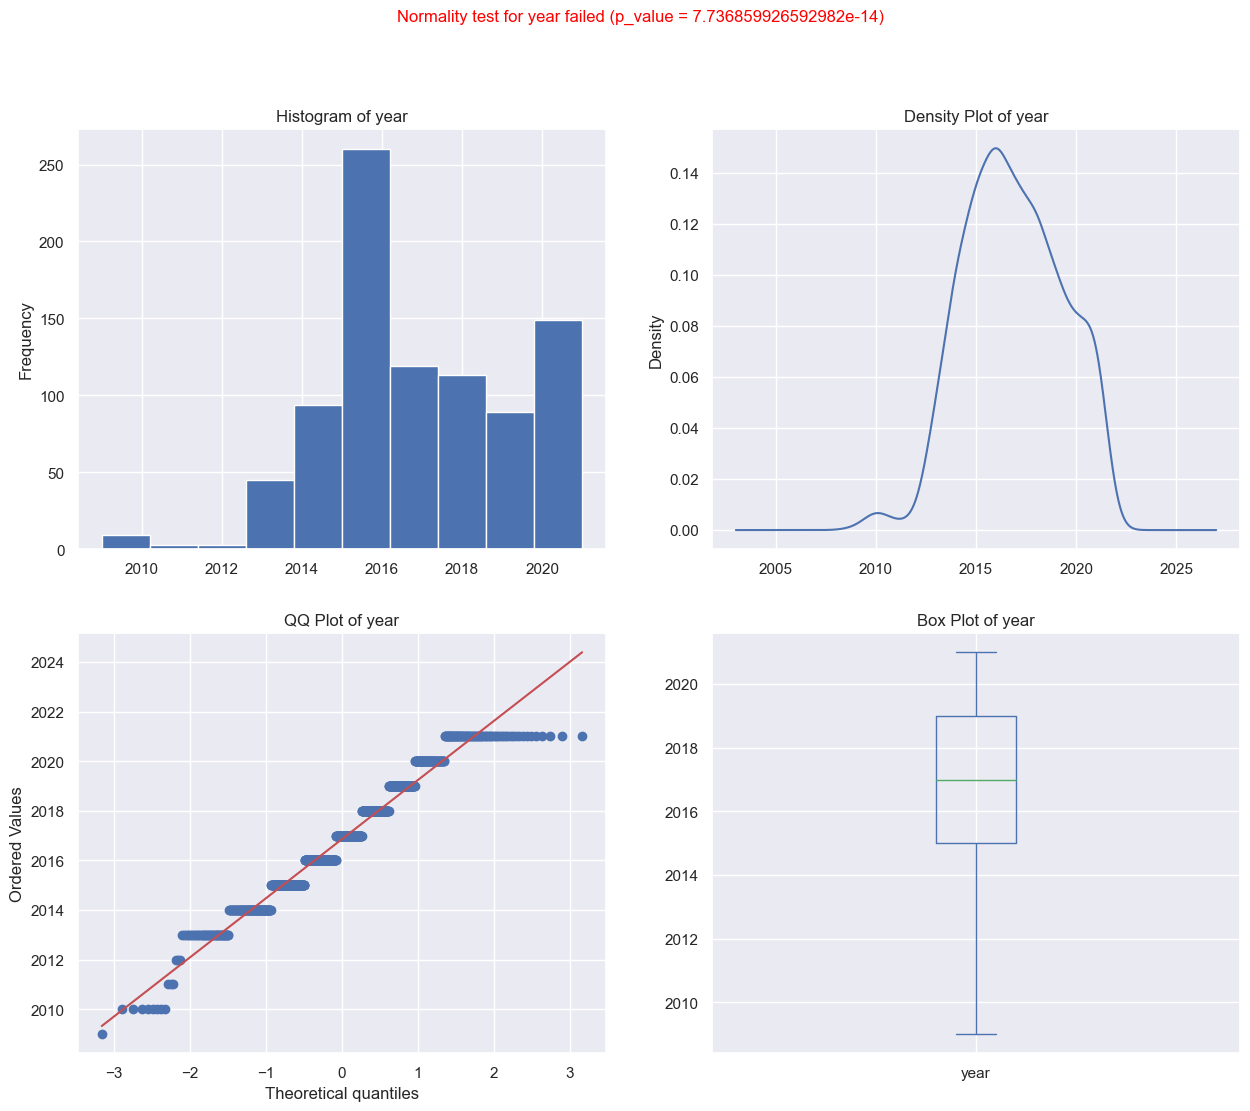

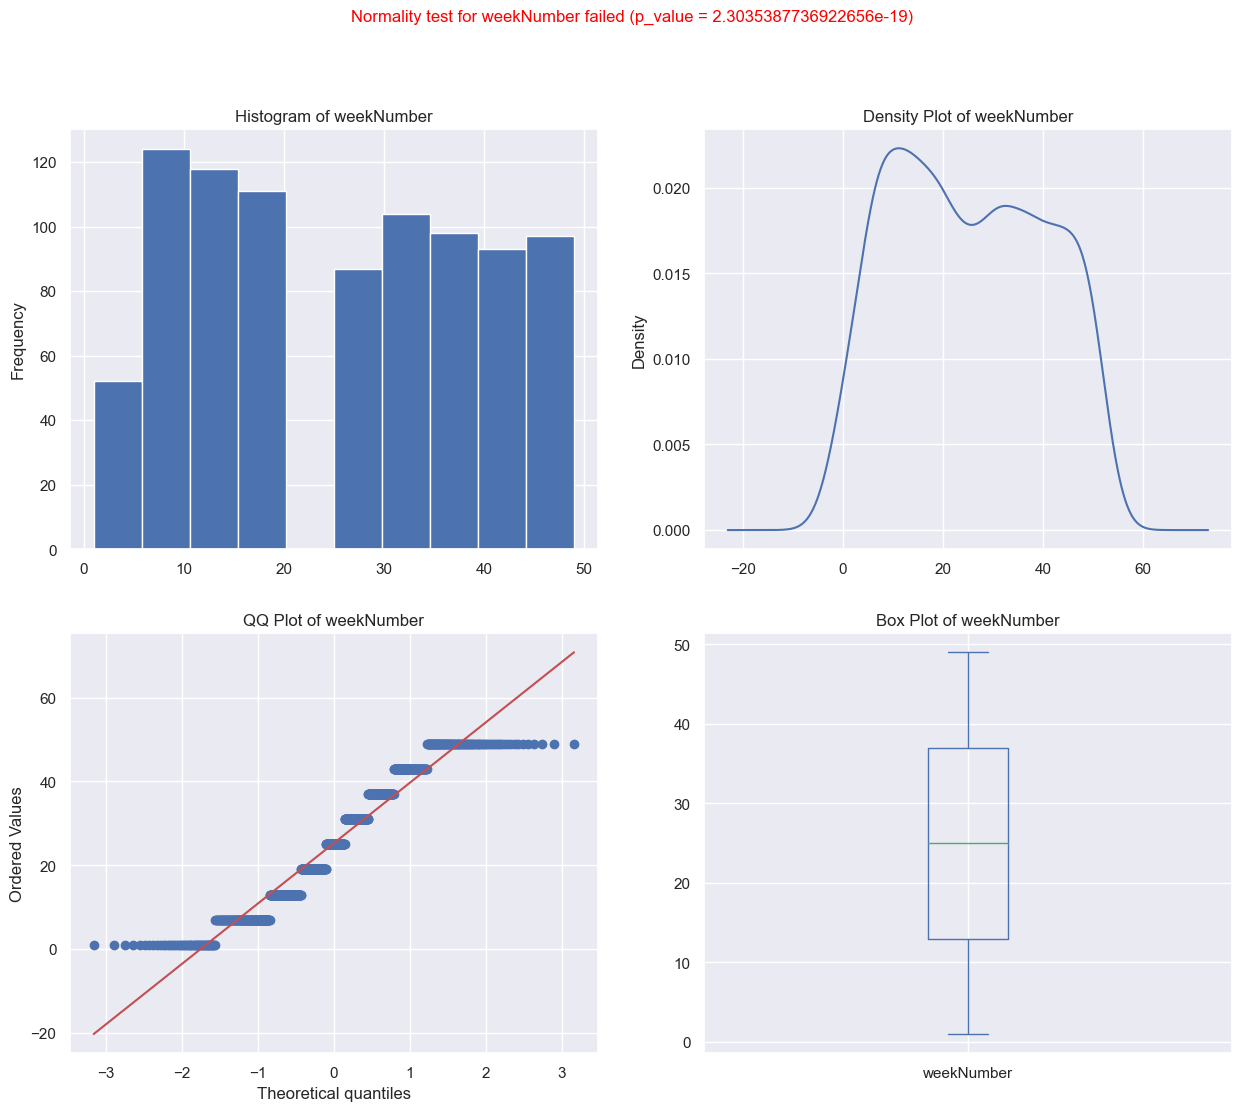

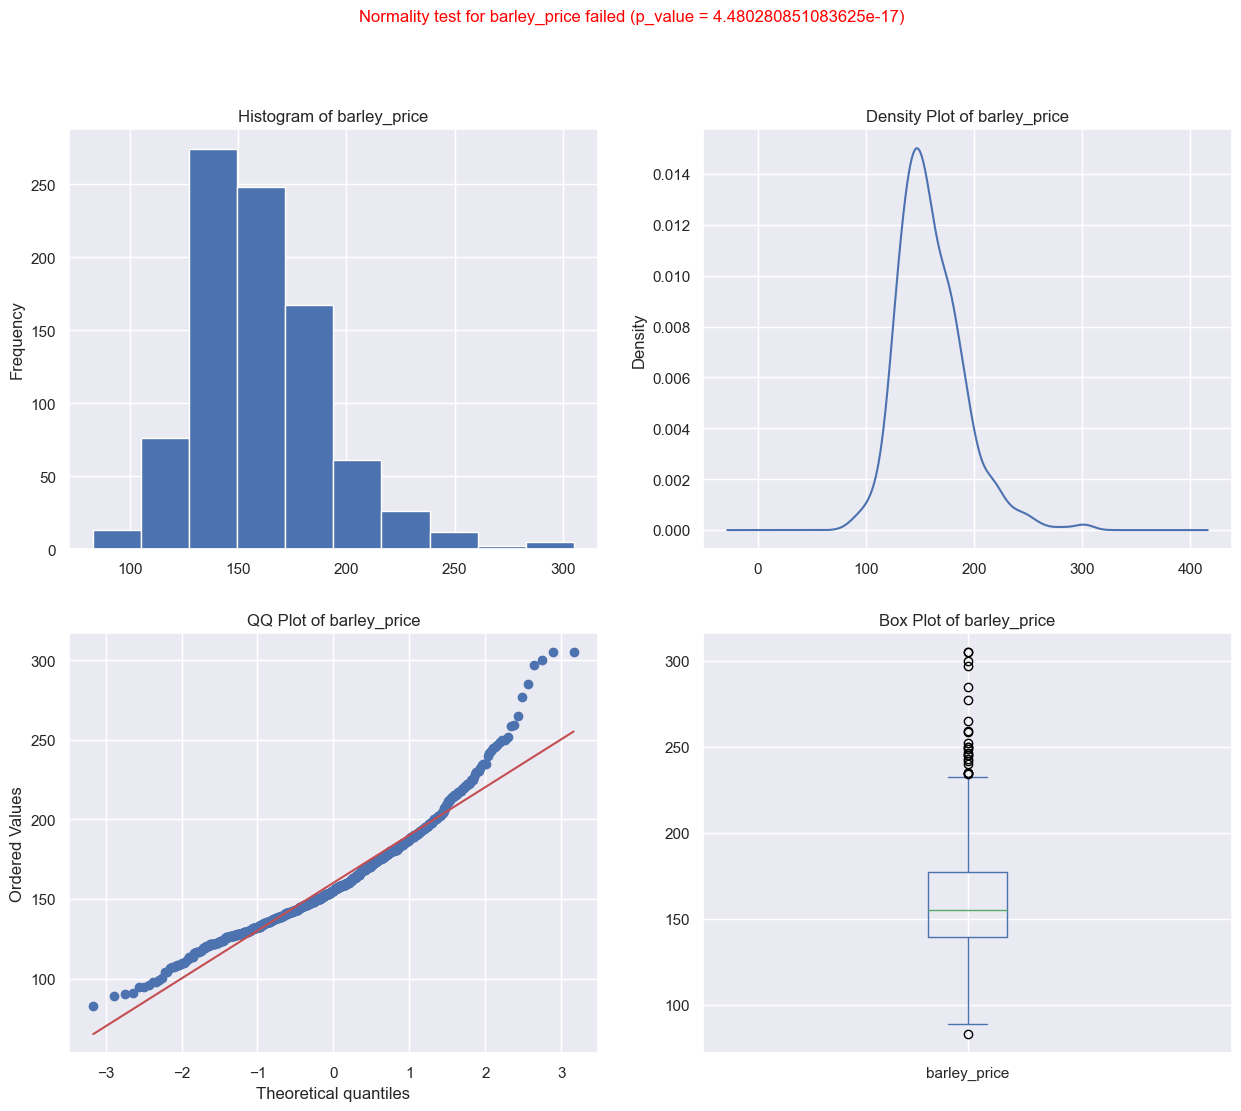

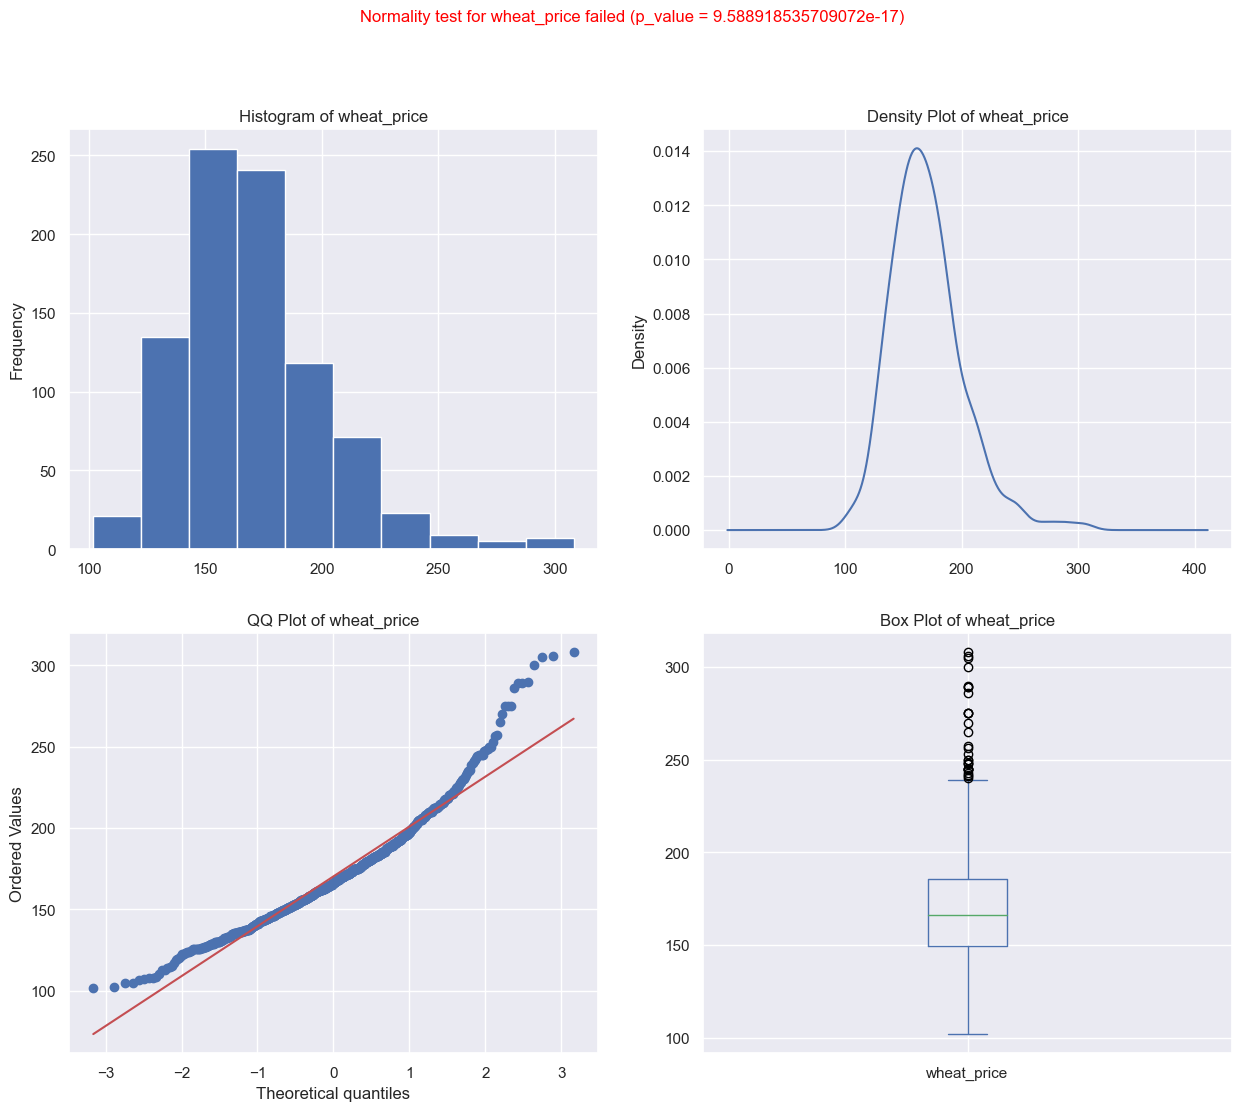

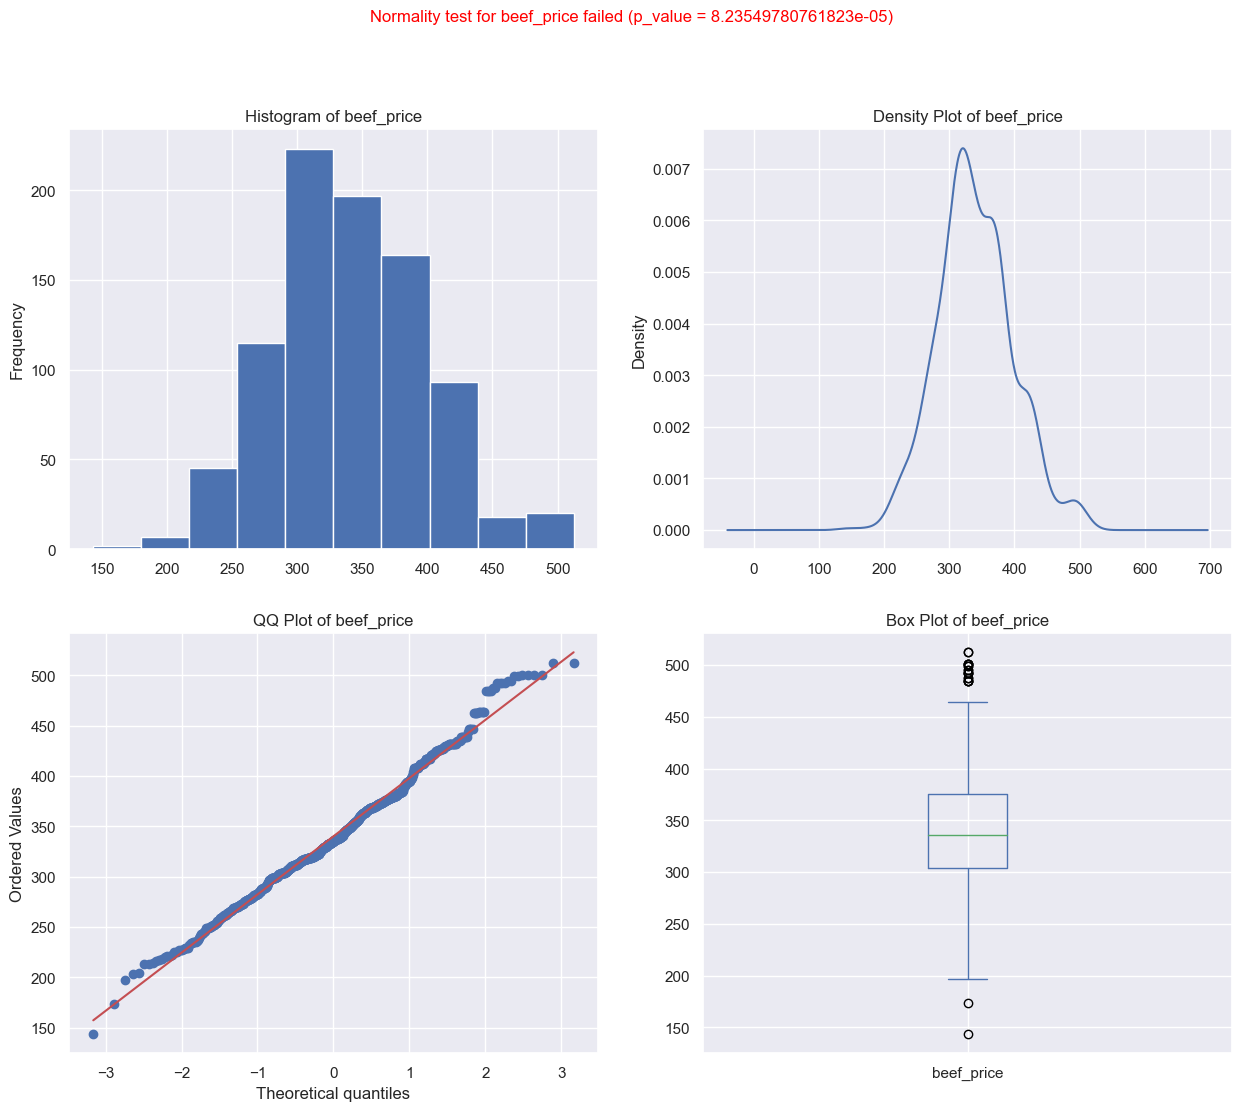

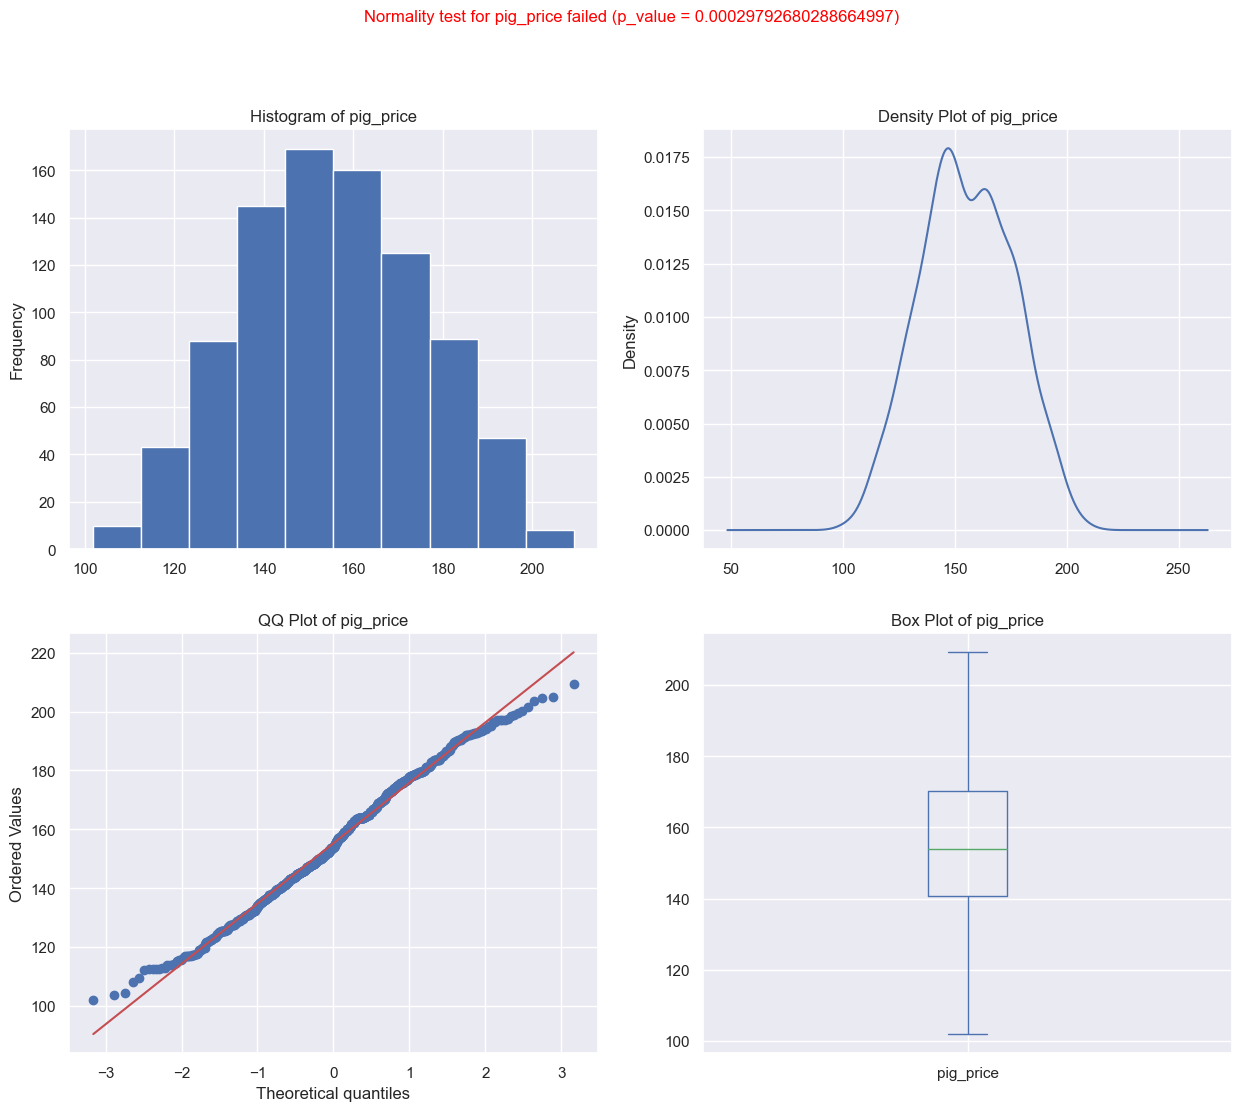

In [179]:
for f in NumericalColumns:
    custom_barplot( df1=df, col1=f)

(869, 11)

C:\Users\stehayes\AppData\Local\Temp\ipykernel_13452\146119605.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(2,2, figsize=(15, 12))


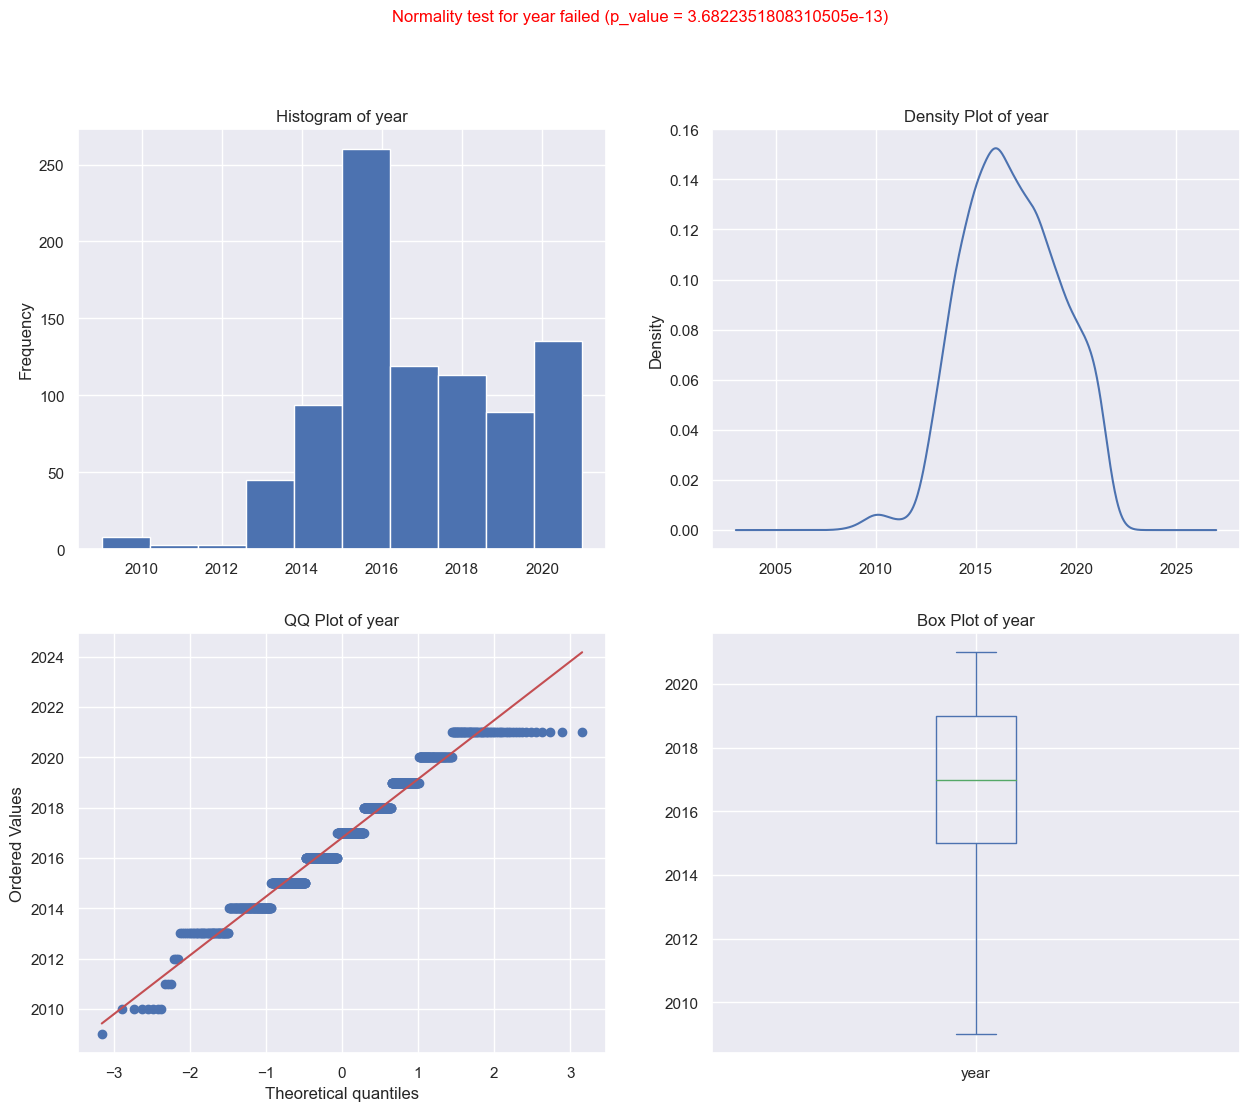

<Figure size 1200x500 with 0 Axes>

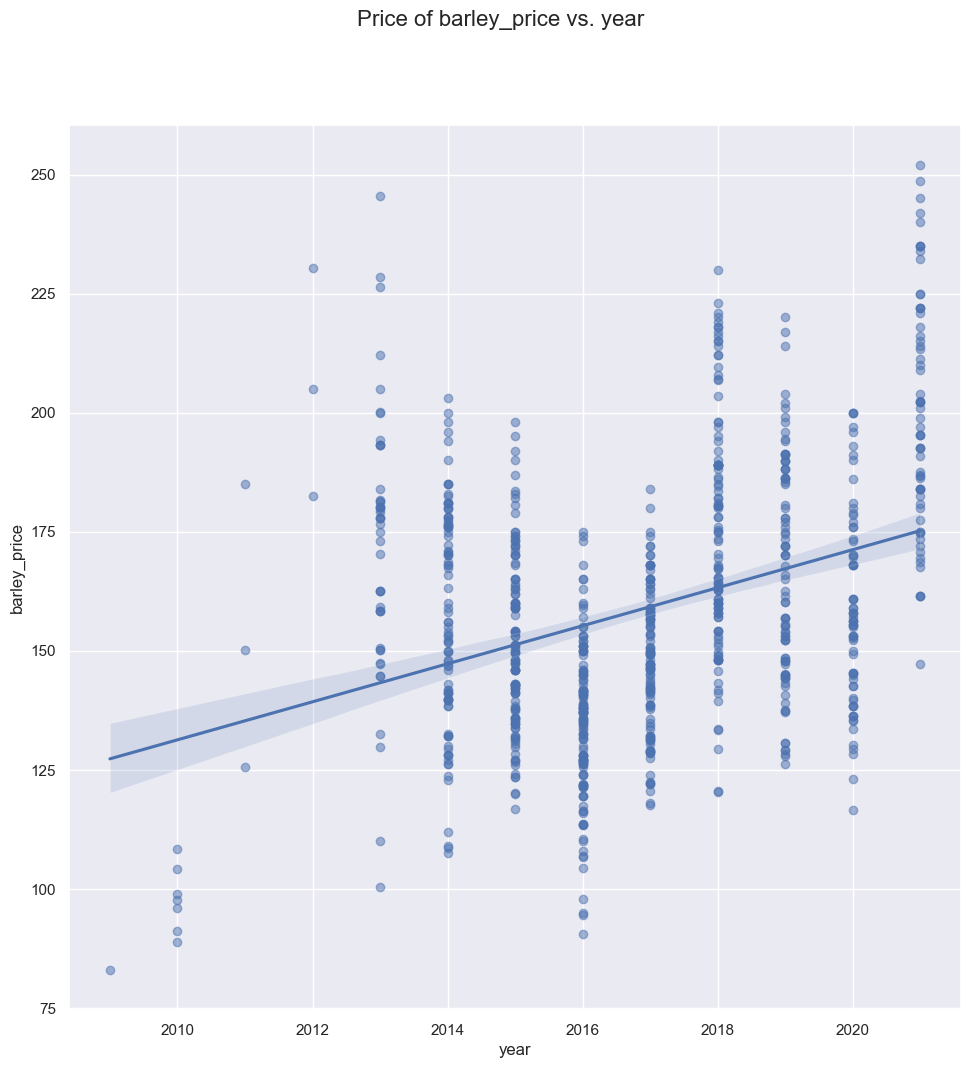

<Figure size 1200x500 with 0 Axes>

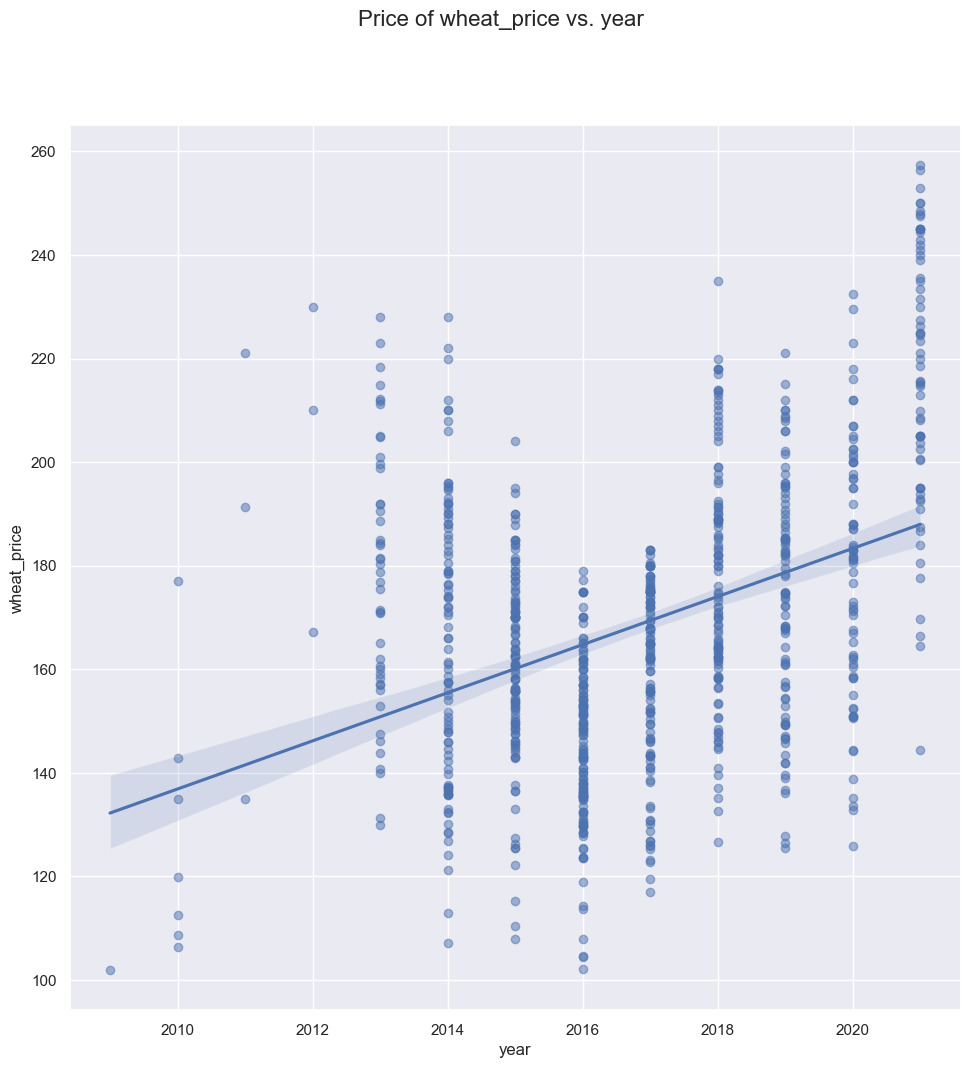

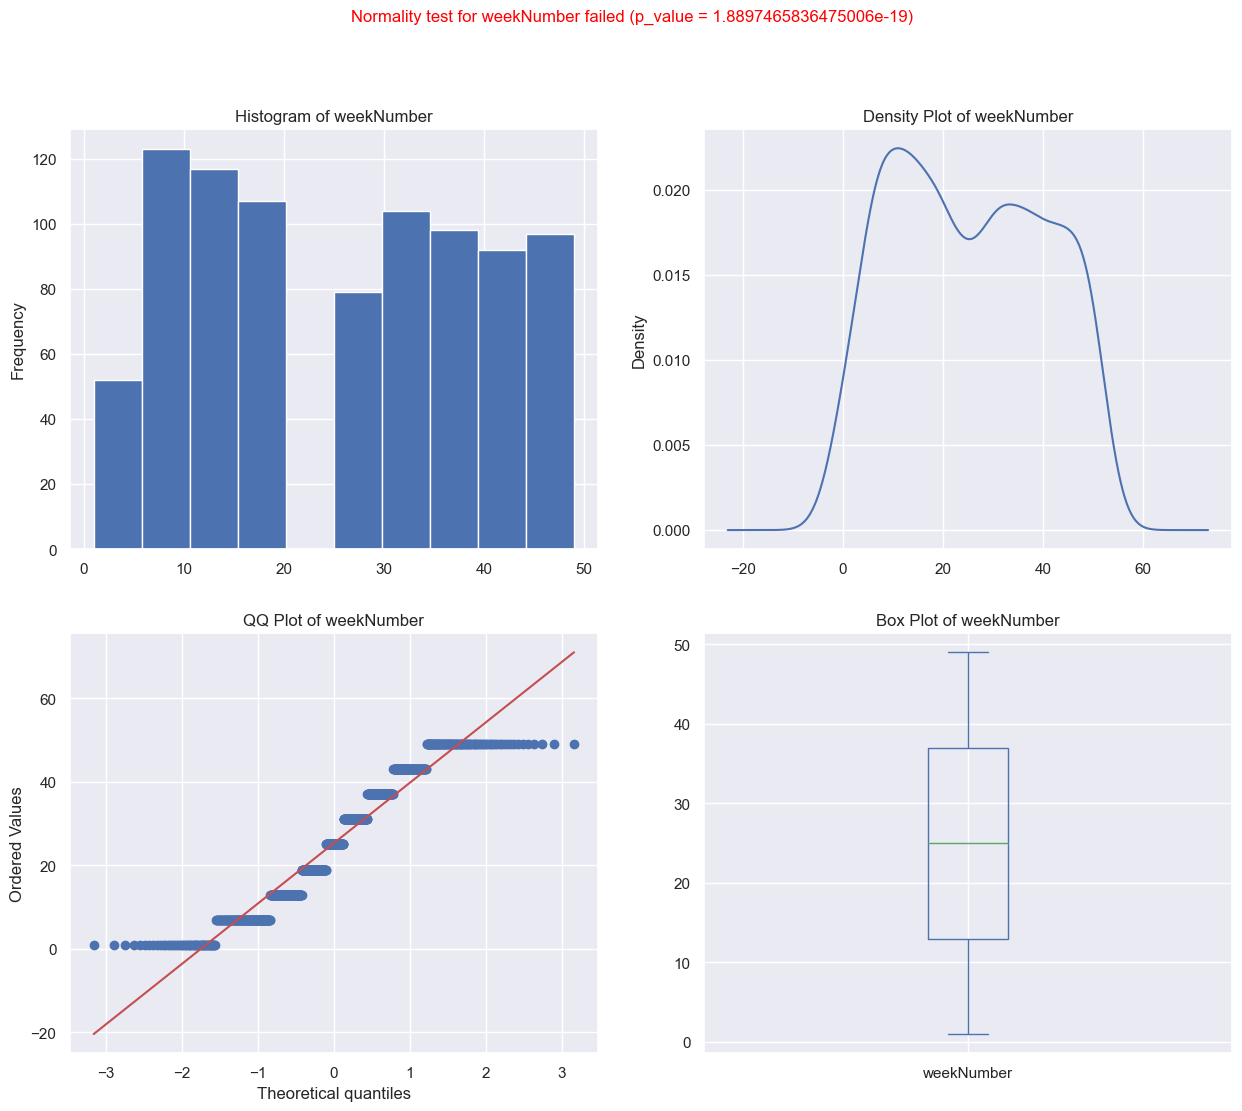

<Figure size 1200x500 with 0 Axes>

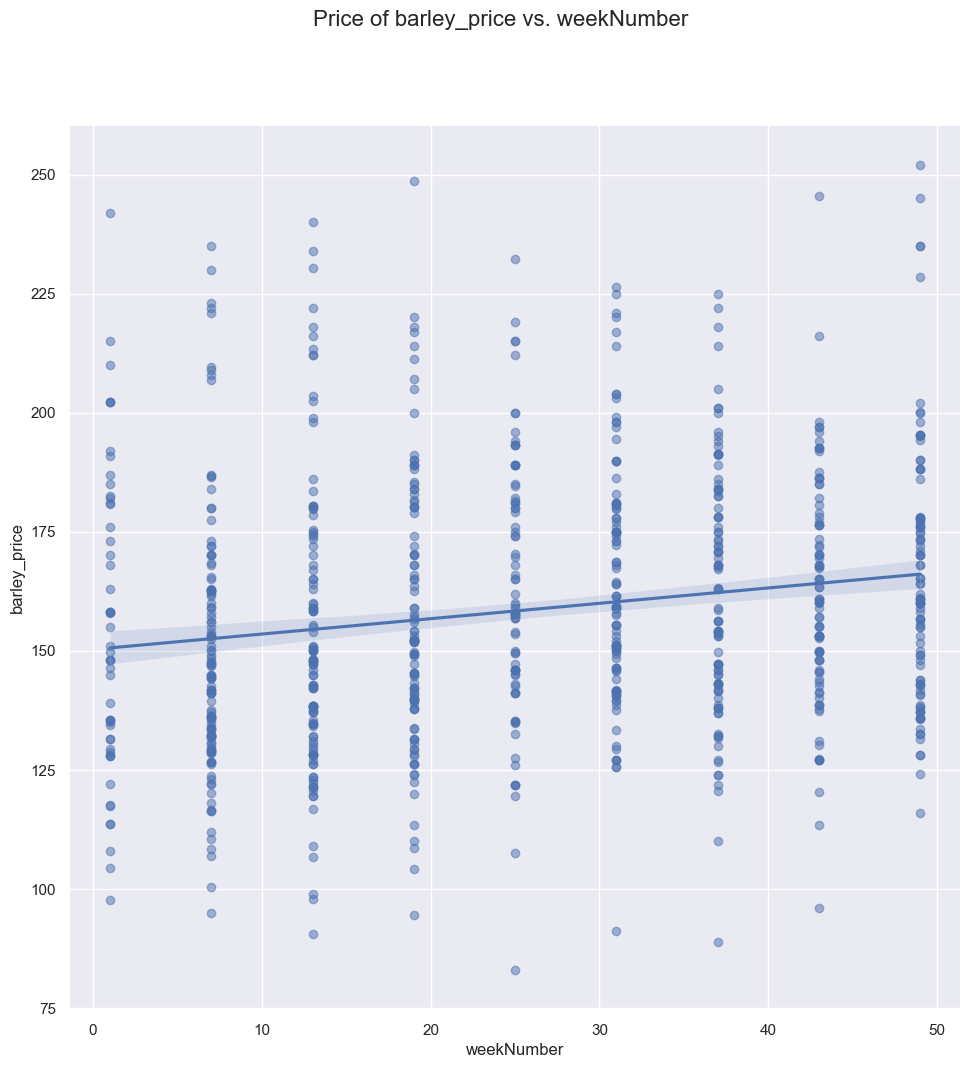

<Figure size 1200x500 with 0 Axes>

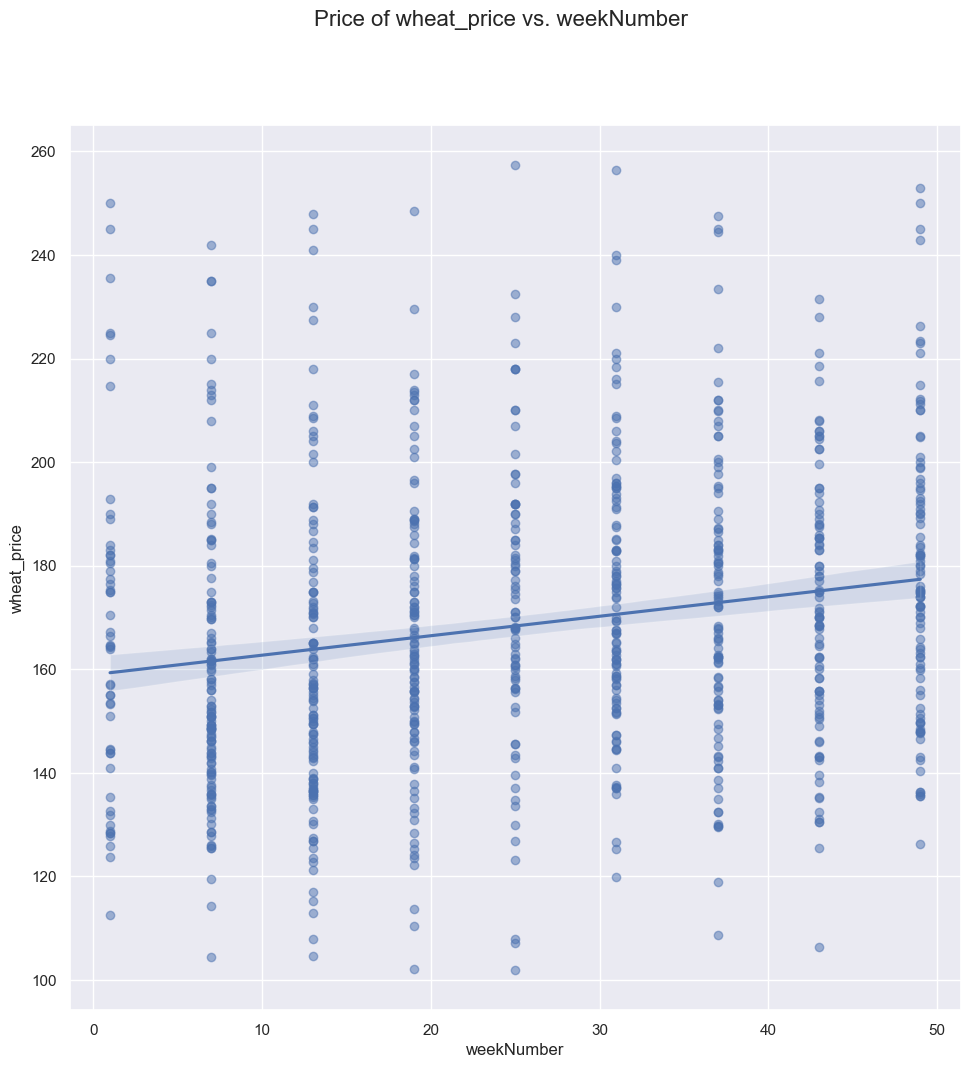

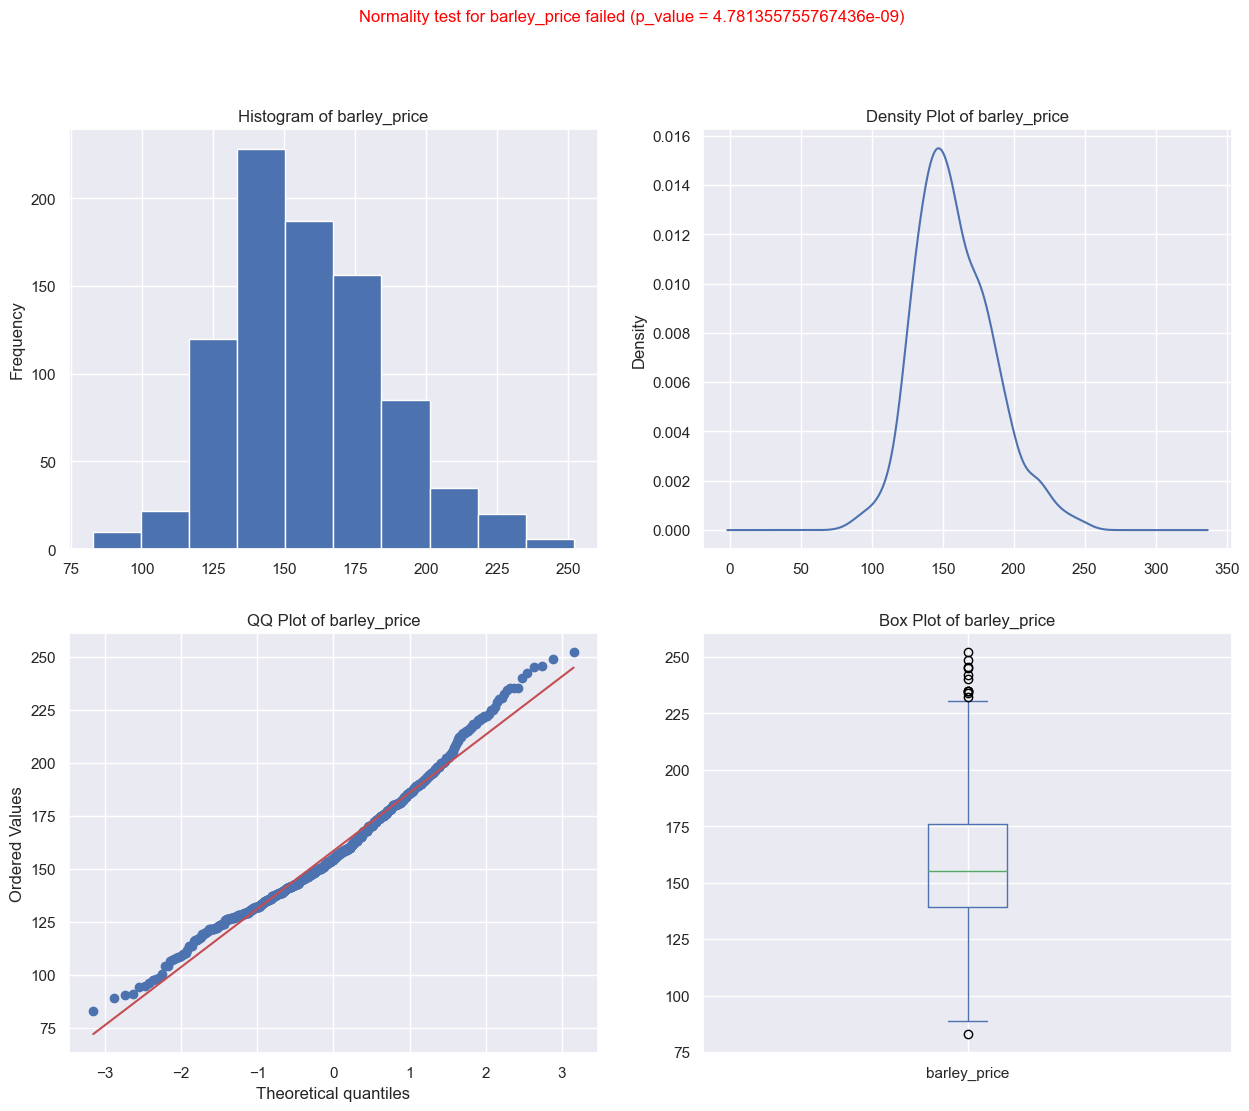

<Figure size 1200x500 with 0 Axes>

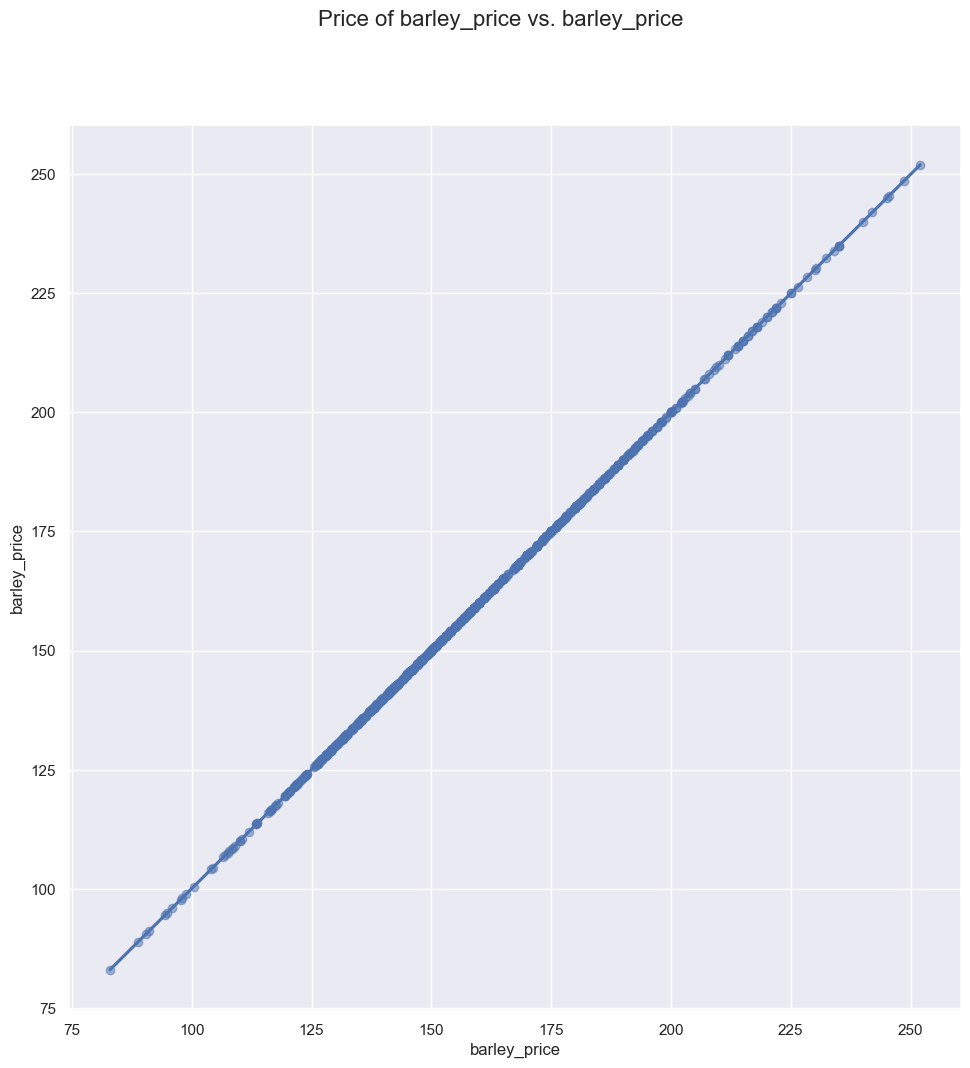

<Figure size 1200x500 with 0 Axes>

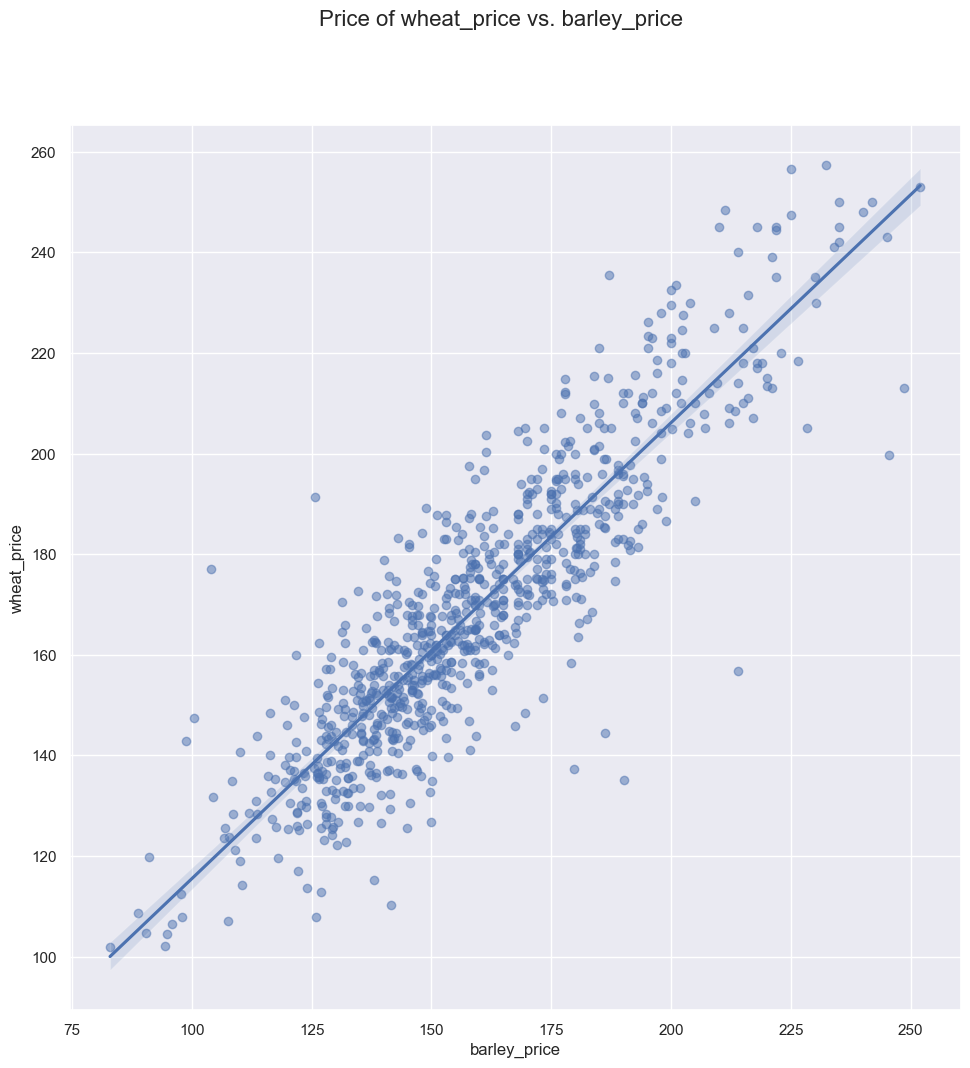

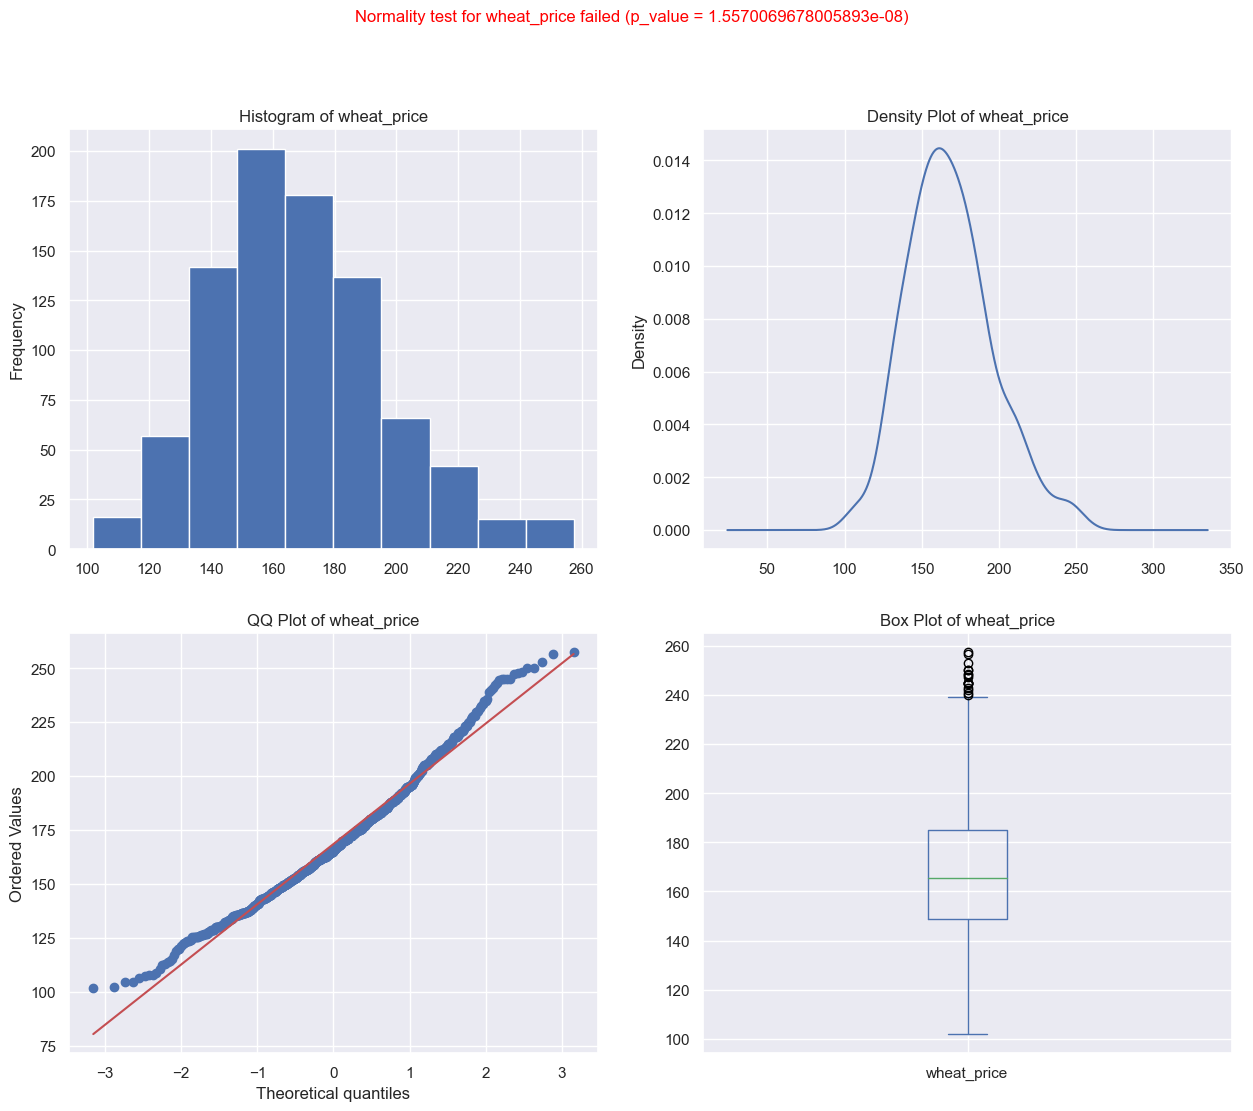

<Figure size 1200x500 with 0 Axes>

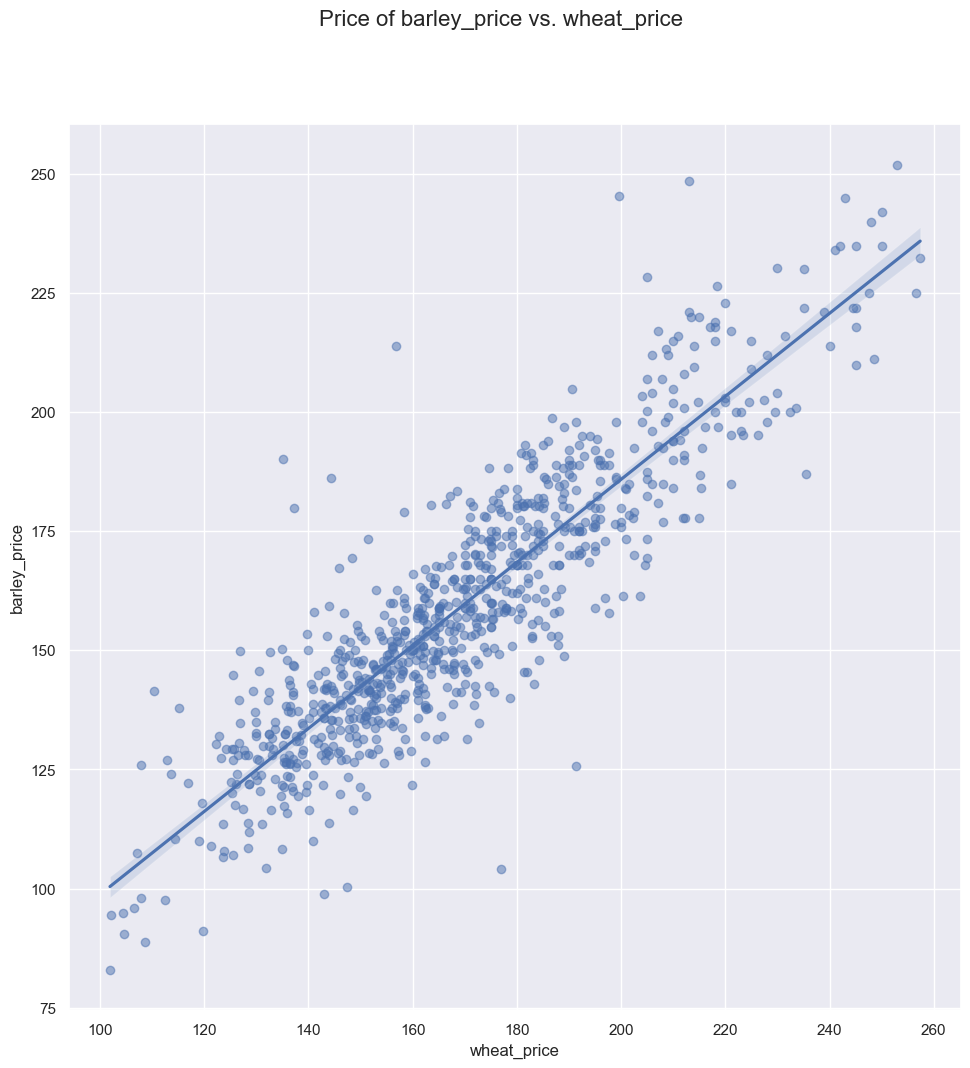

<Figure size 1200x500 with 0 Axes>

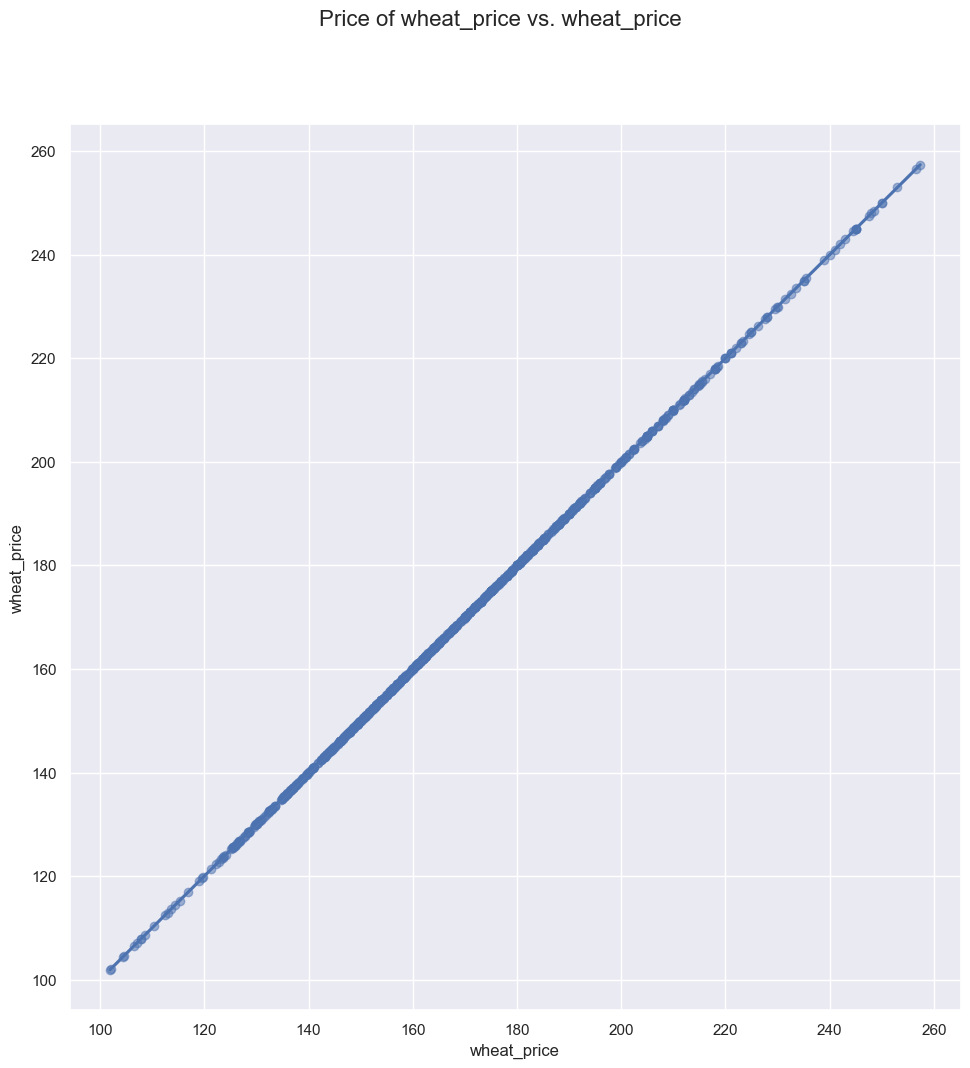

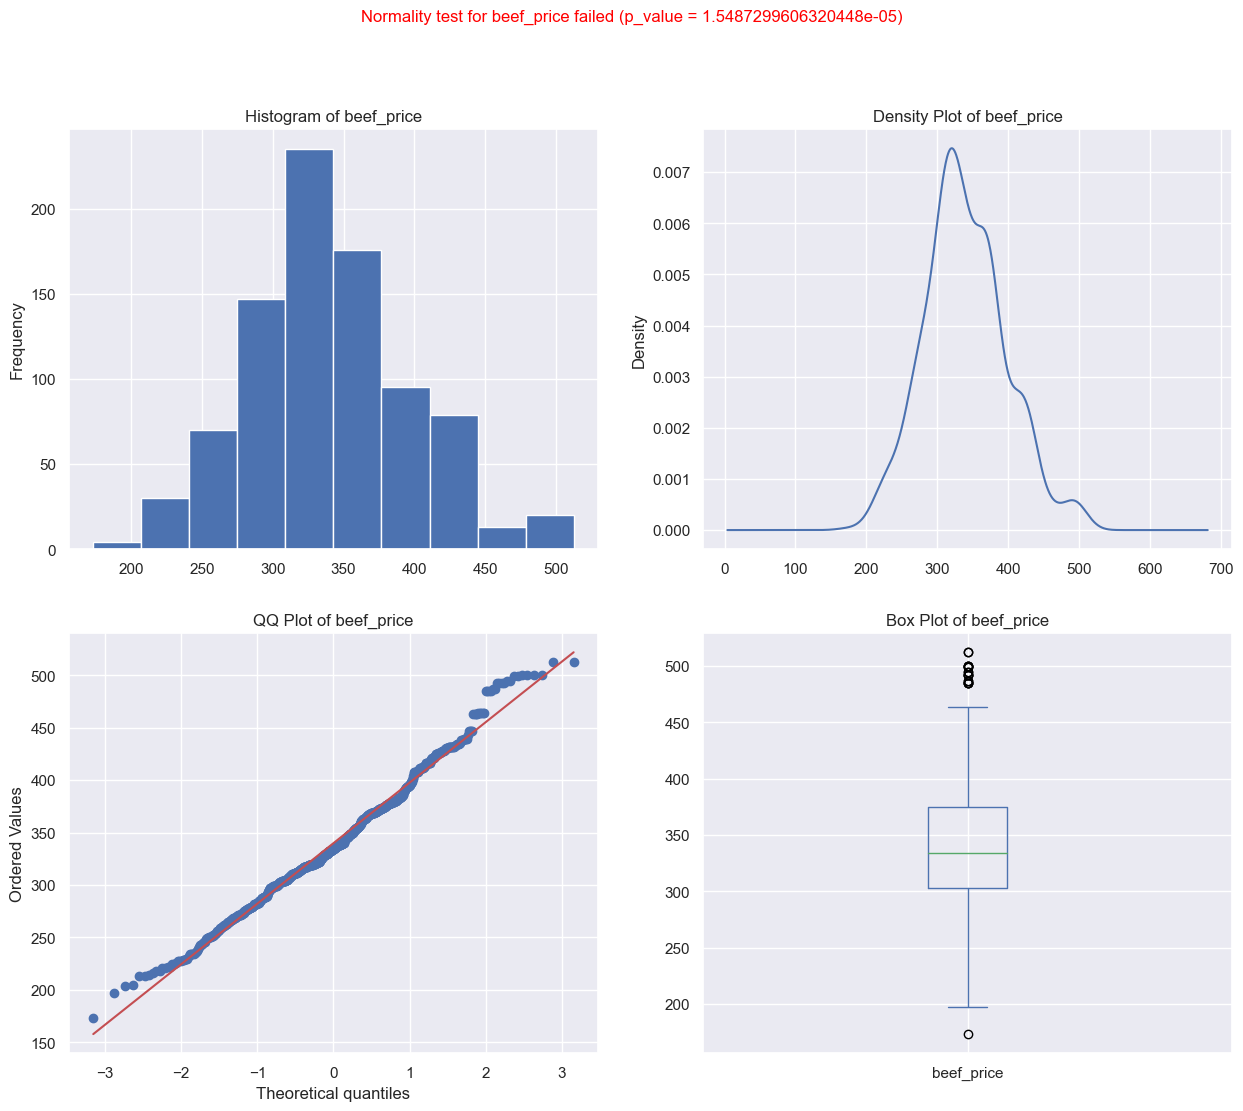

<Figure size 1200x500 with 0 Axes>

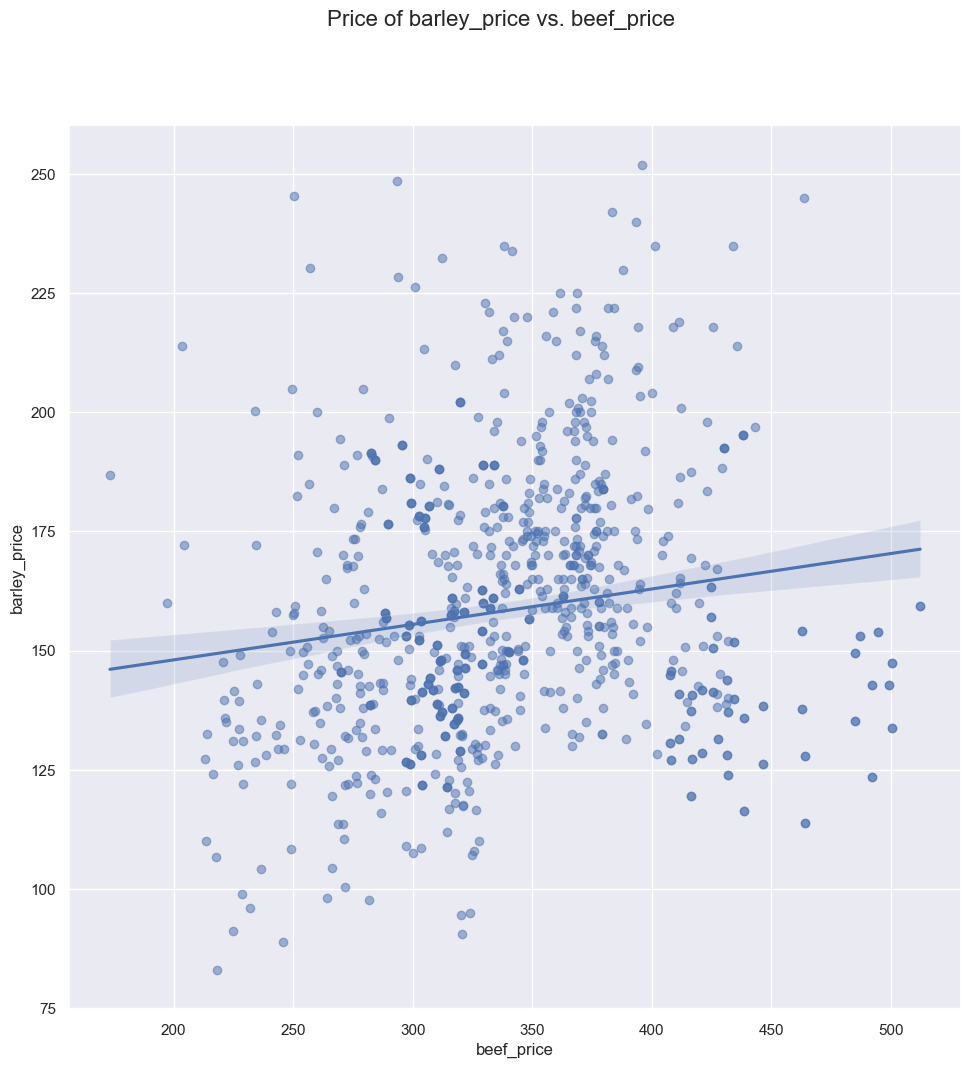

<Figure size 1200x500 with 0 Axes>

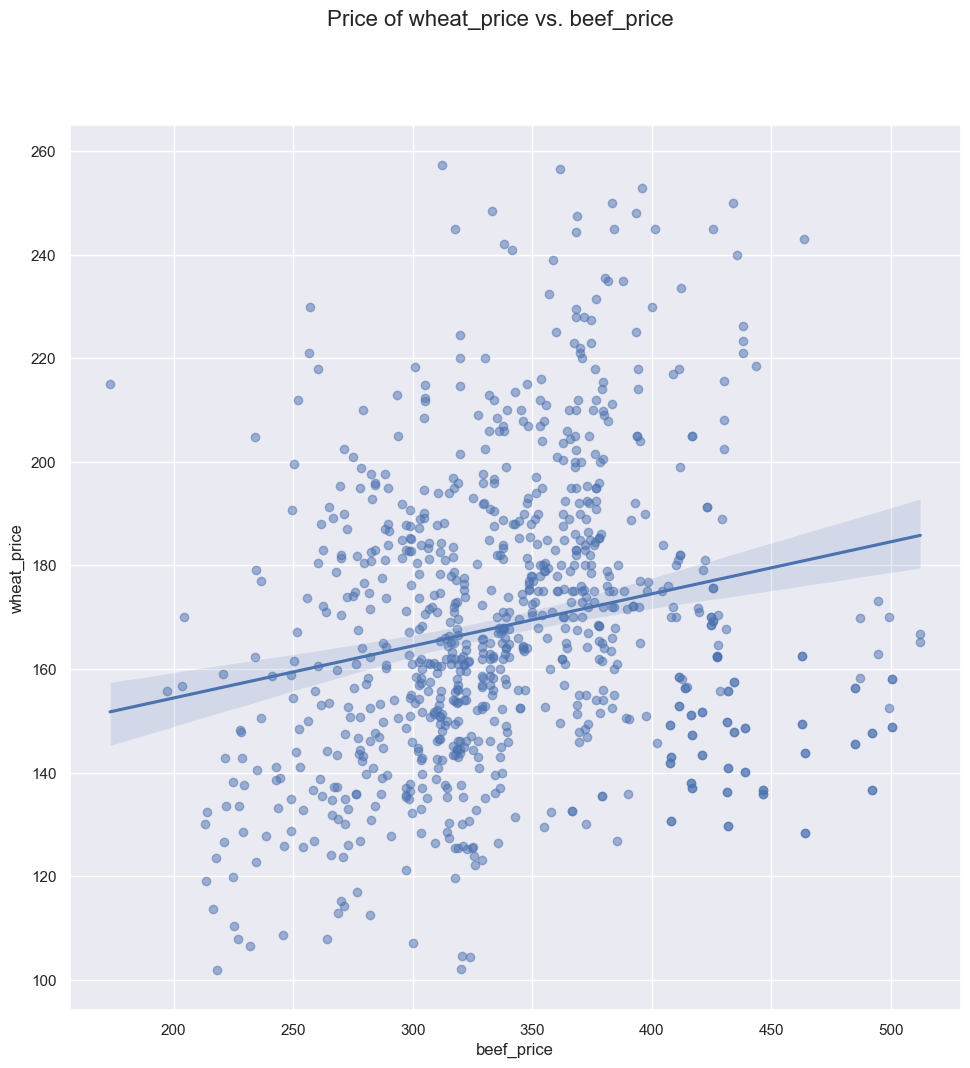

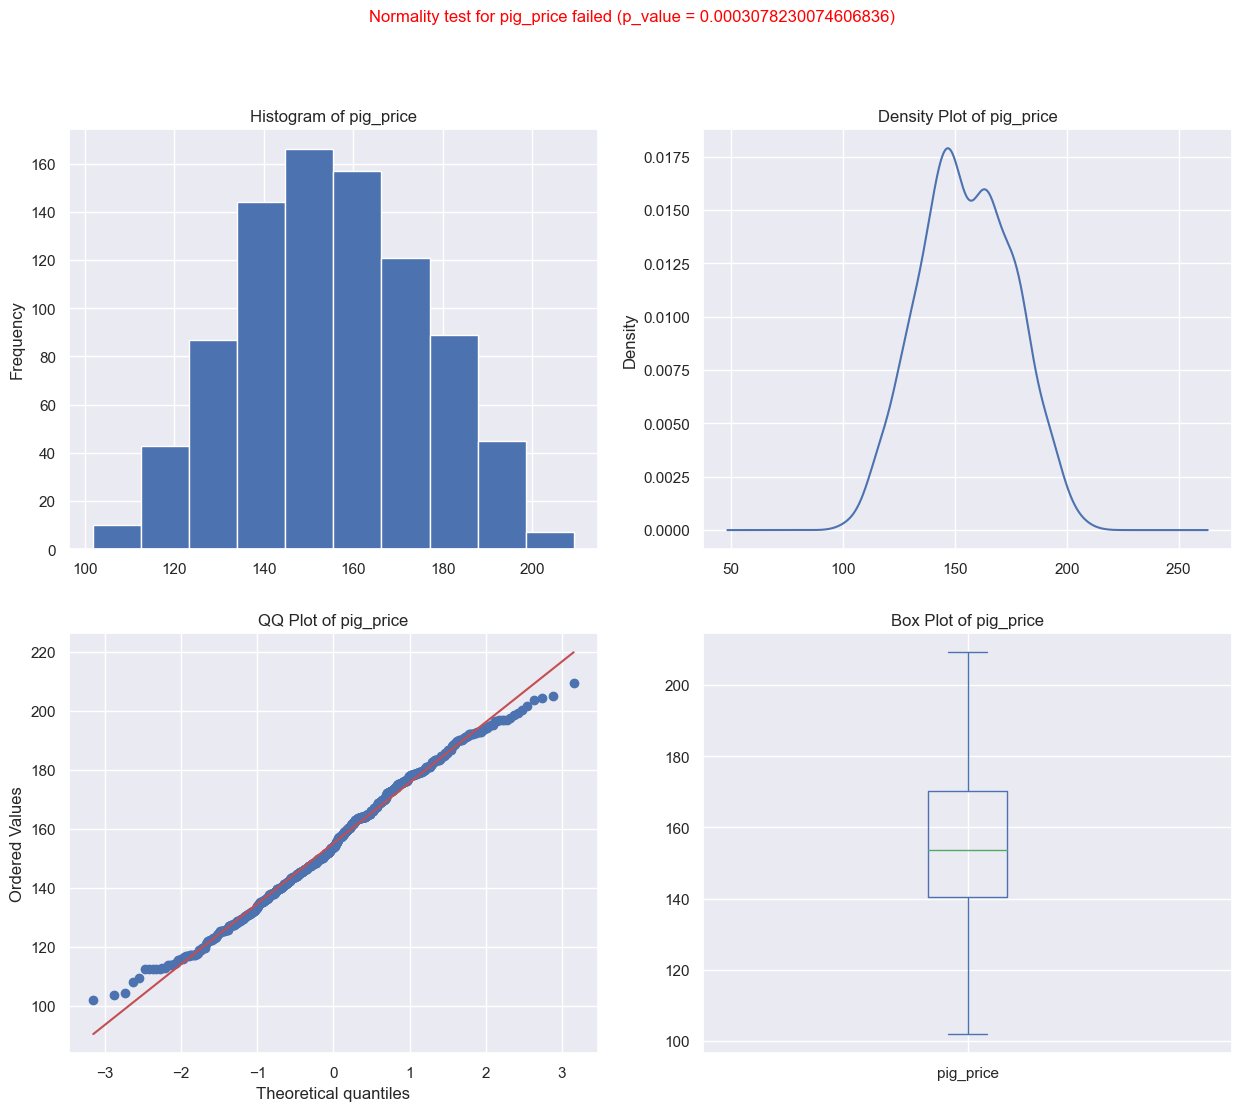

<Figure size 1200x500 with 0 Axes>

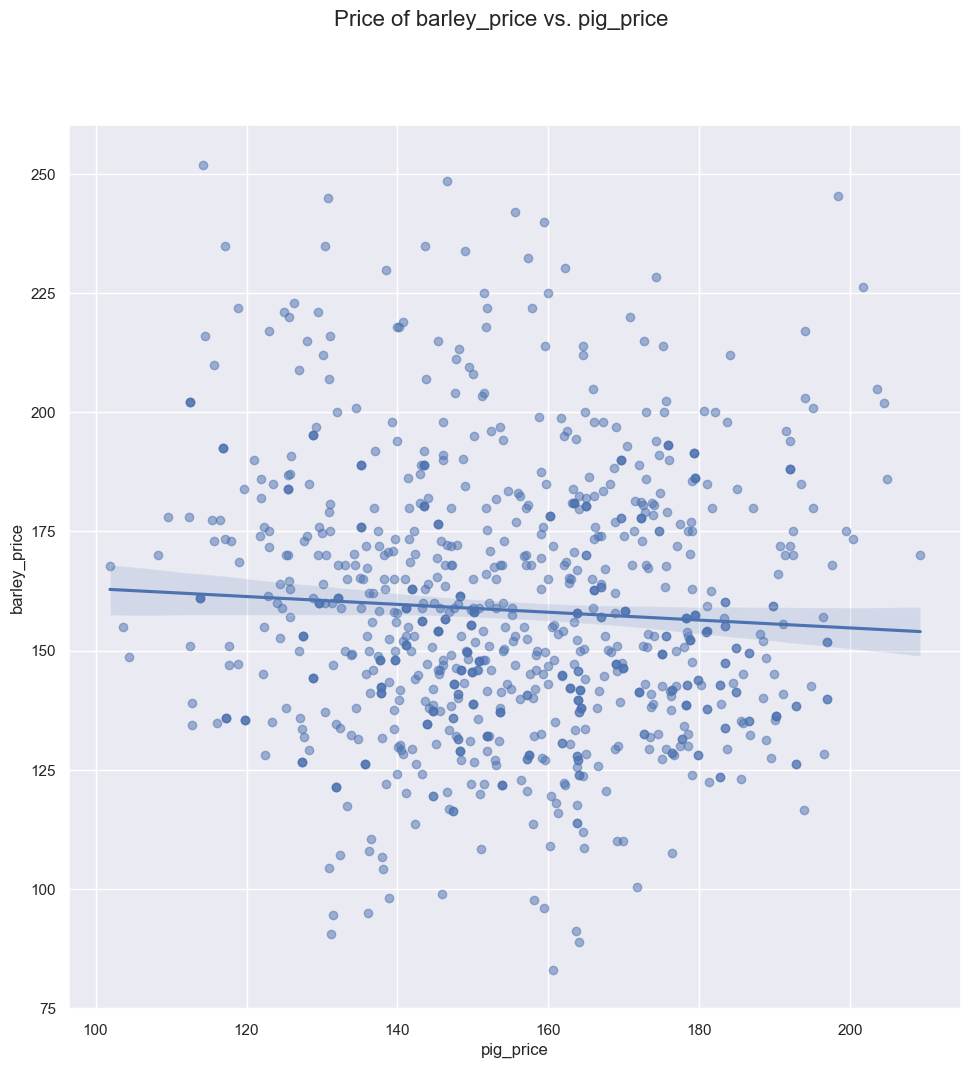

<Figure size 1200x500 with 0 Axes>

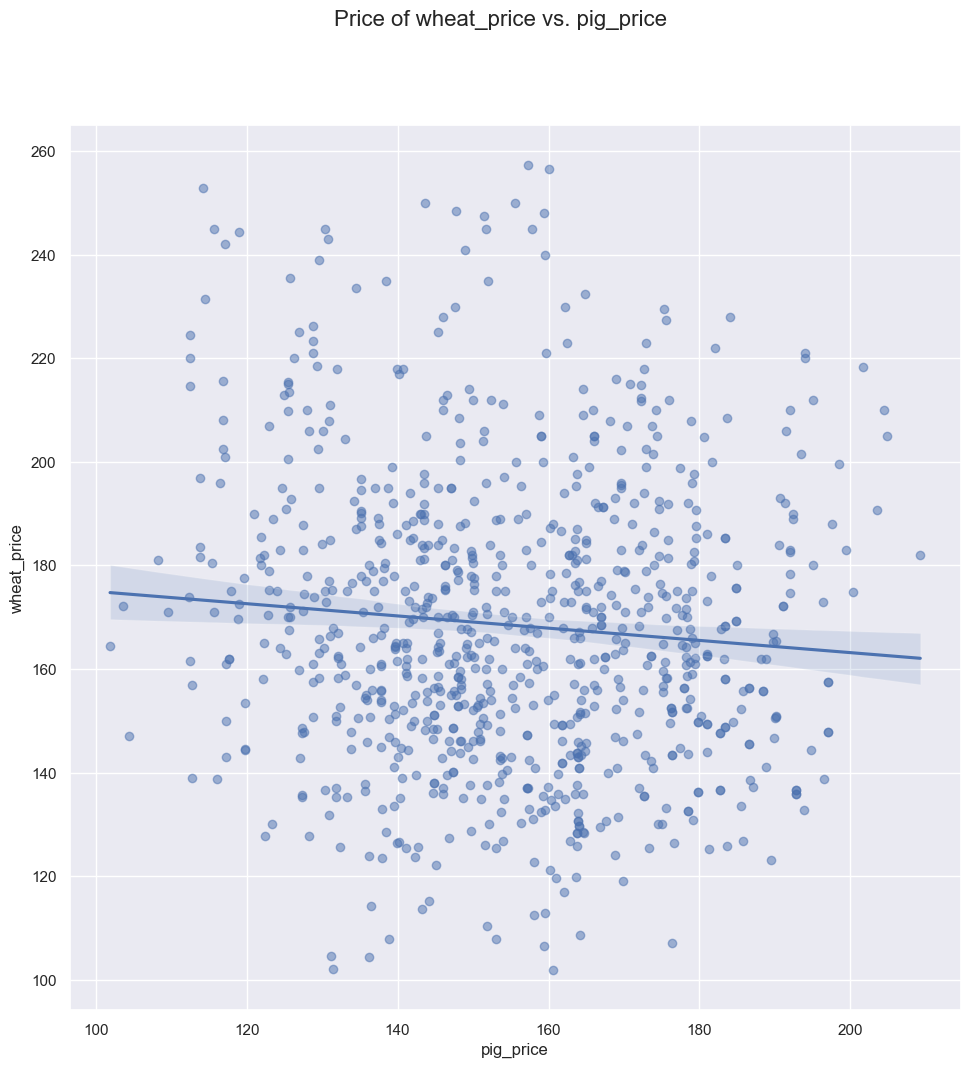

In [180]:
df_new  = df[(df['Zscore_barley_price'] < 3) & (df['Zscore_wheat_price'] < 3)  & (df['Zscore_beef_price'] < 3) & (df['Zscore_pig_price'] < 3)] # remove outliers in all 3 columns
display(df_new.shape)
for f in ['year', 'weekNumber', 'barley_price', 'wheat_price', 'beef_price', 'pig_price']:
    custom_barplot( df1=df_new, col1=f)
    for g in ['barley_price', 'wheat_price']:
        custom_scatterplot(df_new, col_x=f, col_y=g)
    

### 2.3 Data Preparation

All data frame changes go in this section, including the reasons for making the changes.

Taking into consideration the tasks required in the machine learning section, use appropriate data cleaning, engineering, extraction and/or other techniques to structure and enrich your data. 

Rationalize your decisions and implementation, including evidence of how your process has addressed the problems identified in the EDA (Exploratory Data Analysis) stage and how your structured data will assist in the analysis stage. 

This should include visualizations to illustrate your work and evidence to support your methodology.[0-30]


In [ ]:
df_new.drop(['Zscore_barley_price', 'Zscore_wheat_price', 'Zscore_beef_price', 'Zscore_pig_price'], axis=1, inplace=True)
df_new.to_csv('./Data/Final/grain_meat_prices.csv', index=False)

In [52]:
df_text = pd.read_csv('./Data/Final/text_data.csv')
df_text.head()

Key                                              Value
0  1962   -w ■ - -r-irishjournal  of thegrassland  asso...
1  1968  research  for farmip^s^^c £ ''<■corrigendia  f...
2  1969  second  edward  richards  orpen  memorial  lec...
3  1970  mmsome aspects  of efficiency  in beef product...
4  1971  irish  grassland  andchu'ii manimal  productio...

In [54]:
years = list(df['year'].unique())
# filter df_text just for the years in df
display(df_text.head())
df_text = df_text[df_text['Key'].isin(years)]
display(df_text.head())

Key                                              Value
0  1962   -w ■ - -r-irishjournal  of thegrassland  asso...
1  1968  research  for farmip^s^^c £ ''<■corrigendia  f...
2  1969  second  edward  richards  orpen  memorial  lec...
3  1970  mmsome aspects  of efficiency  in beef product...
4  1971  irish  grassland  andchu'ii manimal  productio...

Key                                              Value
35  2009  irish grassland  association  journal2009 volu...
36  2011  24 july 2011  ifa rural development chairman t...
37  2012  16 may 2012  speaking as the main co-ops have ...
38  2013  22 may 2013  ifa environment + rural affairs c...
39  2014  11 september 2014  ifa rural development chair...

In [55]:

df_text['sentiment'] = df_text['Value'].apply(sentiment_scores)
df_text.head()

Overall sentiment dictionary is :  {'neg': 0.041, 'neu': 0.861, 'pos': 0.098, 'compound': 1.0}
Positive
Overall sentiment dictionary is :  {'neg': 0.077, 'neu': 0.826, 'pos': 0.097, 'compound': 0.8878}
Positive
Overall sentiment dictionary is :  {'neg': 0.1, 'neu': 0.803, 'pos': 0.097, 'compound': -0.9903}
Negative
Overall sentiment dictionary is :  {'neg': 0.059, 'neu': 0.837, 'pos': 0.104, 'compound': 0.9963}
Positive
Overall sentiment dictionary is :  {'neg': 0.109, 'neu': 0.792, 'pos': 0.099, 'compound': -0.9347}
Negative
Overall sentiment dictionary is :  {'neg': 0.009, 'neu': 0.918, 'pos': 0.073, 'compound': 0.9943}
Positive
Overall sentiment dictionary is :  {'neg': 0.057, 'neu': 0.862, 'pos': 0.081, 'compound': 0.9971}
Positive
Overall sentiment dictionary is :  {'neg': 0.072, 'neu': 0.829, 'pos': 0.098, 'compound': 0.9974}
Positive
Overall sentiment dictionary is :  {'neg': 0.059, 'neu': 0.832, 'pos': 0.109, 'compound': 0.9995}
Positive
Overall sentiment dictionary is :  {'neg

Key                                              Value  sentiment
35  2009  irish grassland  association  journal2009 volu...     1.0000
36  2011  24 july 2011  ifa rural development chairman t...     0.8878
37  2012  16 may 2012  speaking as the main co-ops have ...    -0.9903
38  2013  22 may 2013  ifa environment + rural affairs c...     0.9963
39  2014  11 september 2014  ifa rural development chair...    -0.9347

In [56]:

df_text = df_text[['Key', 'sentiment']]
df_text.rename(columns={'Key': 'year'}, inplace=True)



In [57]:
df_text.head()

year  sentiment
35  2009     1.0000
36  2011     0.8878
37  2012    -0.9903
38  2013     0.9963
39  2014    -0.9347

In [140]:
df = pd.read_csv('./Data/Final/grain_meat_prices.csv')
df.columns.values

array(['memberStateCode', 'weekNumber', 'wheat_price', 'barley_price',
       'year', 'pig_price', 'beef_price'], dtype=object)

In [100]:
df = df.merge(df_text, on='year', how='right')
df.head()

memberStateCode  weekNumber  wheat_price  barley_price  year  pig_price  \
0              RO          25       101.91         82.95  2009     160.61   
1              RO          13       134.85        150.22  2011     154.16   
2              RO          31       191.31        125.66  2011     166.54   
3              RO          43       220.99        184.95  2011     159.62   
4              RO           1       167.14        182.41  2012     164.08   

   beef_price  sentiment  
0      217.98     1.0000  
1      298.55     0.8878  
2      264.91     0.8878  
3      256.50     0.8878  
4      251.58    -0.9903

Collect and develop a dataset based on the agriculture topic related to Ireland as well as other parts of the world. 

Perform a sentimental analysis for an appropriate agricultural topic (e.g., product price, feed quality etc…) for producers and consumers point of view in Ireland.
[0 - 25]


### 2.4 Modeling

Clustering, Linear regression, random forest.

Use of multiple models (at least two) to compare and contrast results and insights gained.

Describe the rationale and justification for the choice of machine learning models for the above-mentioned scenario. 

Machine Learning models can be used for Prediction, Classification, Clustering, sentiment analysis, recommendation systems and Time series analysis. 

You should plan on trying multiple approaches (at least two) with proper selection of hyperparameters using GridSearchCV method. 

You can choose appropriate features from the datasets and a target feature to answer the question asked in the scenario in the case of supervised learning.
[0 - 30]


In [141]:
# add the sentiment column to the list of numerical columns
#NumericalColumns = set().union(NumericalColumns, ['sentiment'])
NumericalColumns = ['year', 'weekNumber', 'barley_price', 'wheat_price', 'beef_price', 'pig_price']


In [142]:
df = pd.get_dummies(df, columns=['memberStateCode'])

In [143]:
df.columns.values

array(['weekNumber', 'wheat_price', 'barley_price', 'year', 'pig_price',
       'beef_price', 'memberStateCode_AT', 'memberStateCode_BE',
       'memberStateCode_CZ', 'memberStateCode_DE', 'memberStateCode_FR',
       'memberStateCode_HU', 'memberStateCode_IE', 'memberStateCode_LT',
       'memberStateCode_LV', 'memberStateCode_NL', 'memberStateCode_PL',
       'memberStateCode_PT', 'memberStateCode_RO', 'memberStateCode_SK',
       'memberStateCode_UK'], dtype=object)

In [144]:
# need to scale the data  before modeling

# MinMaxScaler scales the data between 0 and 1 i.e. (x - min(x)) / (max(x) - min(x))
scaler = MinMaxScaler() 
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

weekNumber  wheat_price  barley_price      year  pig_price  beef_price  \
0       0.500     0.000000      0.000000  0.000000   0.546860    0.131587   
1       0.000     0.068176      0.087134  0.083333   0.523011    0.320263   
2       0.125     0.212568      0.150311  0.083333   0.458357    0.223845   
3       0.250     0.263700      0.094292  0.083333   0.409633    0.162802   
4       0.375     0.483149      0.125170  0.083333   0.336501    0.186847   

   memberStateCode_AT  memberStateCode_BE  memberStateCode_CZ  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   memberStateCode_DE  ...  memberStateCode_HU  memberStateCode_IE  \
0                 0.0  ...                 0.0                 0.0   
1                 0.0  ...                 0.0                 0.0   
2                 0.0  ...                 0.0                 0.0   
3                 0.0  ...                 0.0                 0.0   
4                 0.0  ...                 0.0                 0.0   

   memberStateCode_LT  memberStateCode_LV  memberStateCode_NL  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   memberStateCode_PL  memberStateCode_PT  memberStateCode_RO  \
0                 0.0                 0.0                 1.0   
1                 0.0                 0.0                 1.0   
2                 0.0                 0.0                 1.0   
3                 0.0                 0.0                 1.0   
4                 0.0                 0.0                 1.0   

   memberStateCode_SK  memberStateCode_UK  
0                 0.0                 0.0  
1                 0.0                 0.0  
2                 0.0                 0.0  
3                 0.0                 0.0  
4                 0.0                 0.0  

[5 rows x 21 columns]

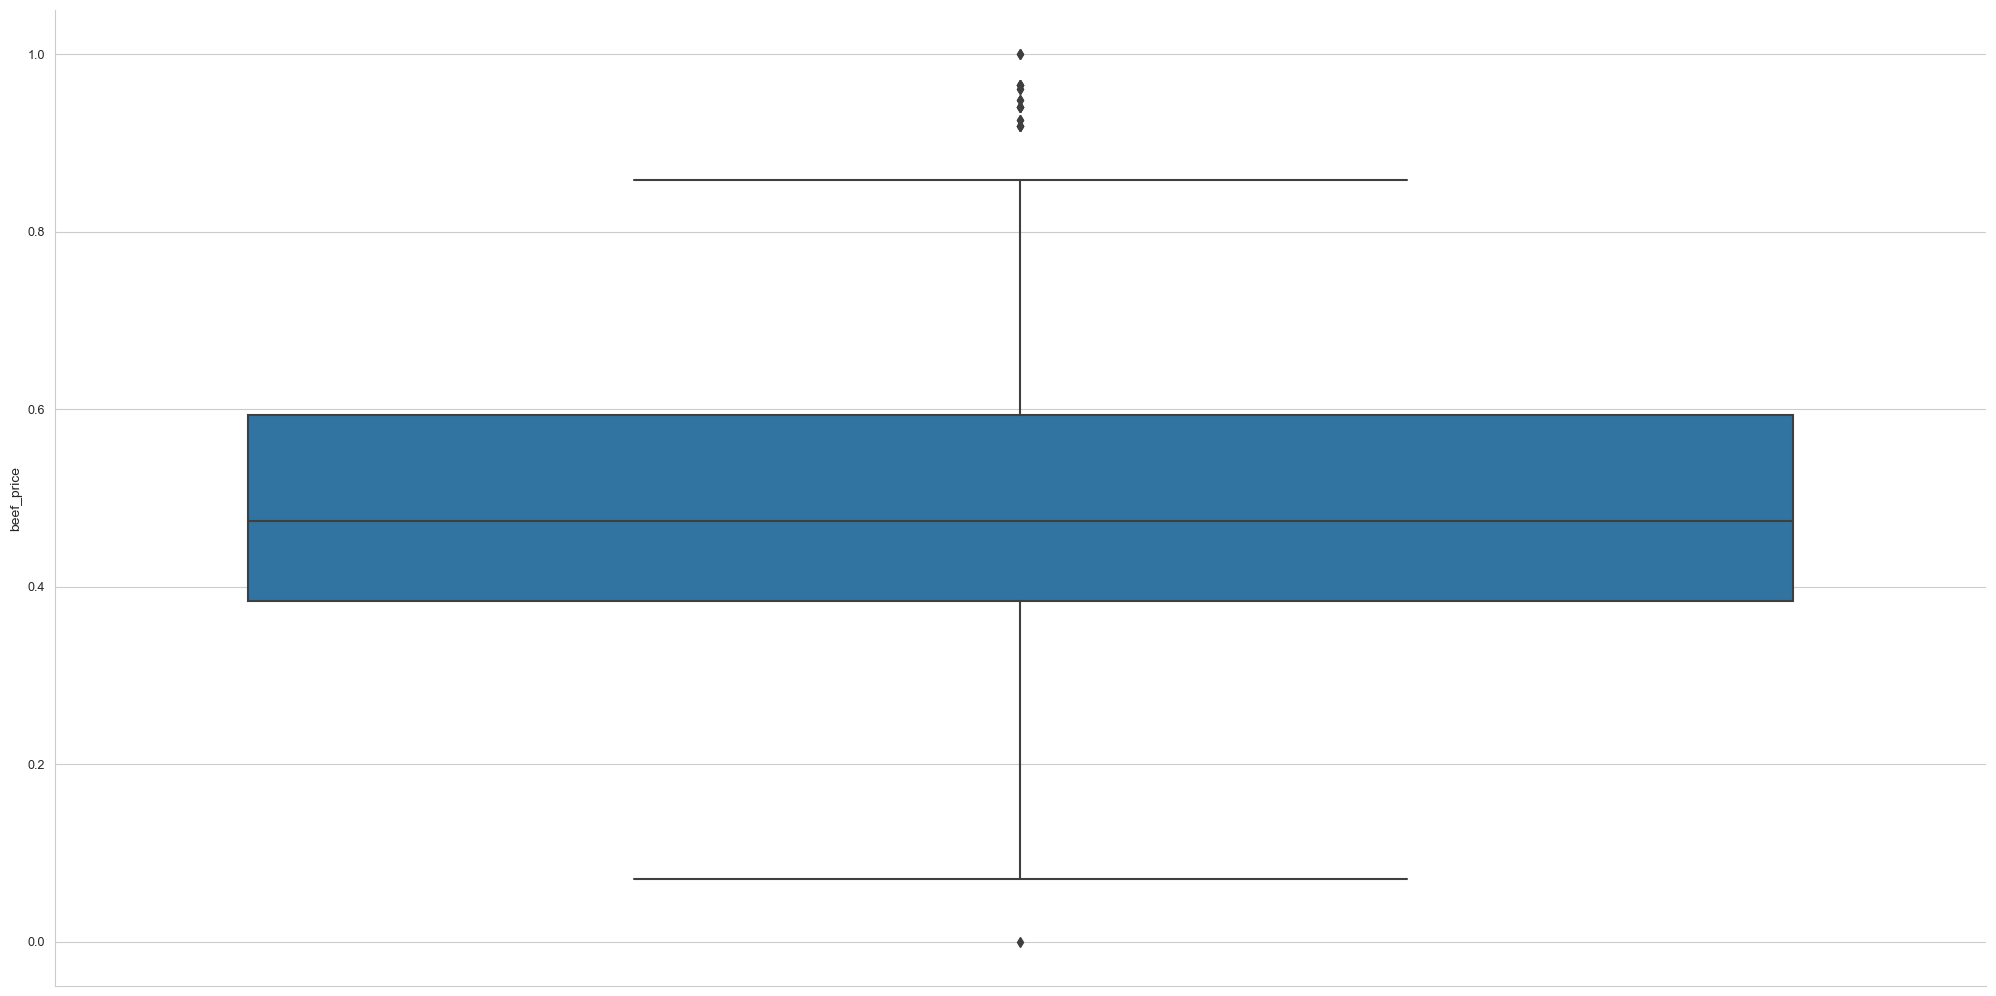

In [145]:
sns.catplot(data=df,  y = 'beef_price' ,   kind='box', height=10, aspect=2);

In [146]:
# model the beef price first
X = df.drop(['beef_price'], axis=1)
y = df['beef_price']
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)  

In [147]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(695, 20)
(174, 20)
(695,)
(174,)


You should train and test for Supervised Learning and other appropriate metrics for unsupervised/ semi-supervised machine learning models that you have chosen. 

Use cross validation to provide authenticity of the modelling outcomes. 

You can apply dimensionality reduction methods to prepare the dataset based on your machine learning modelling requirements.
[0 - 30]


### Linear Regression

In [148]:

folds = KFold(n_splits=5, shuffle=True, random_state=42)
# specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, len(X_train.columns)))}]

In [149]:
lrm = LinearRegression()   
lrm.fit(X_train, y_train) #fit an OLS model
rfe = RFE(lrm) #apply RFE
# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)               

Fitting 5 folds for each of 19 candidates, totalling 95 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19]}],
             return_train_score=True, scoring='r2', verbose=1)

In [150]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.style.background_gradient(cmap='summer_r')

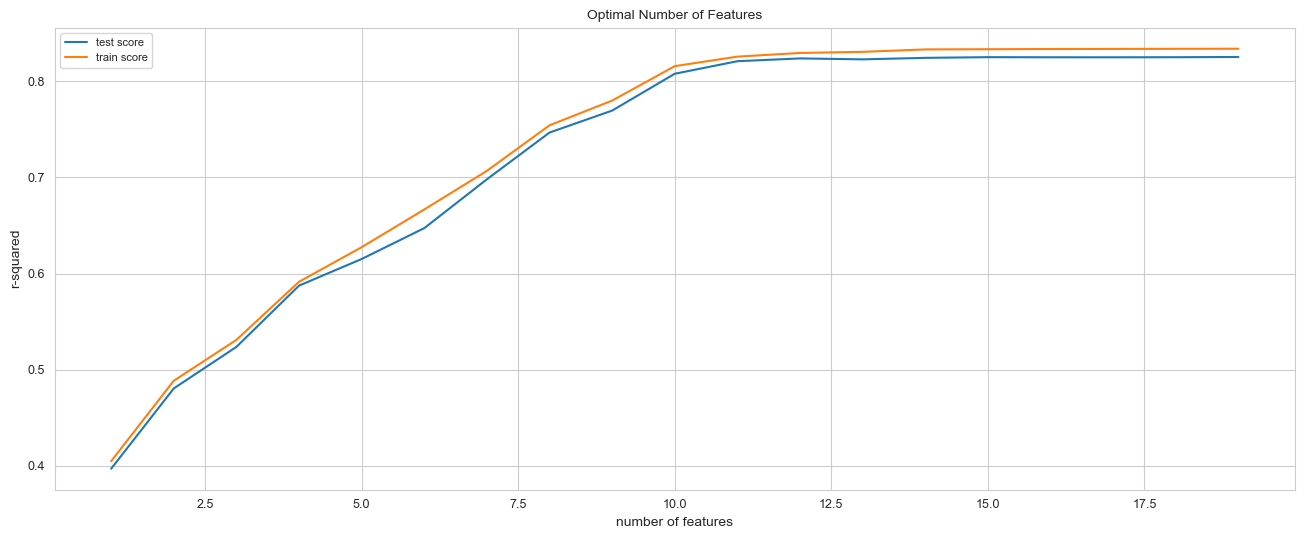

In [151]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])

plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

### Ridge Regression

In [164]:
# Using GridSearch for parameter optimization
ridgeregr = GridSearchCV(Ridge(),
                    param_grid={
                        'alpha': [0.001, 0.01, 0.1, 1, 10, 20, 30]
                    }, verbose=1,return_train_score=True)

ridgeregr.fit(X_train, y_train)

ridge = ridgeregr.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [165]:
# cv results
cv_results = pd.DataFrame(ridgeregr.cv_results_)
cv_results.style.background_gradient(cmap='summer_r')

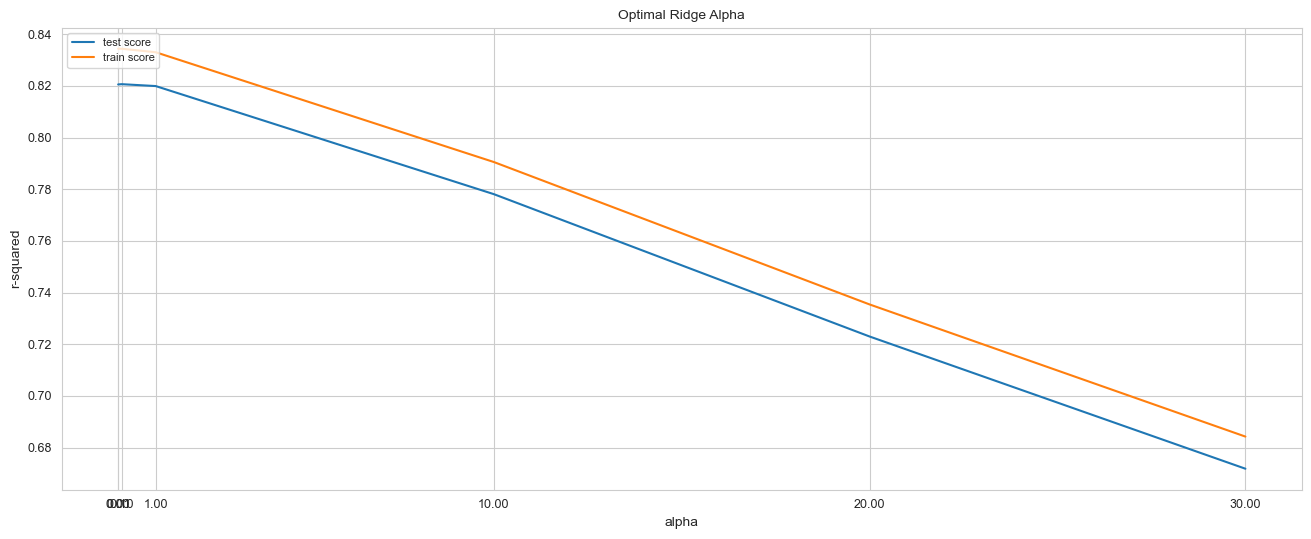

In [167]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_alpha"], cv_results["mean_test_score"])
plt.plot(cv_results["param_alpha"], cv_results["mean_train_score"])
plt.xticks(ticks= [0.001, 0.01, 0.1, 1, 10, 20, 30])
plt.xlabel('alpha')
plt.ylabel('r-squared')
plt.title("Optimal Ridge Alpha")
plt.legend(['test score', 'train score'], loc='upper left')

In [168]:
# Making predictions here
y_preds_train = ridge.predict(X_train)
y_preds_test_ridge = ridge.predict(X_test)

print("R-squared of the model in training set is: {}".format(ridge.score(X_train, y_train)))
print("The optimal value of alpha is: {}".format(ridge.alpha))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_ridge)**(1/2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_ridge) / y_test)) * 100))

R-squared of the model in training set is: 0.8330904000293371
The optimal value of alpha is: 0.1
-----Test set statistics-----
R-squared of the model in test set is: 0.8435712338946566
Root mean squared error of the prediction is: 0.064510526105708
Mean absolute percentage error of the prediction is: 10.5034306651689


###  Lasso Regression 

In [ ]:
# using GridSearch for parameter optimization
lassoregr = GridSearchCV(Lasso(),
                    param_grid={
                        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]
                    }, verbose=1,
                        return_train_score=True)

lassoregr.fit(X_train, y_train)

lasso = lassoregr.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-02, tolerance: 1.658e-03
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.600e-02, tolerance: 1.621e-03
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-02, toleranc

In [ ]:
# cv results
cv_results = pd.DataFrame(lassoregr.cv_results_)
cv_results.style.background_gradient(cmap='summer_r')

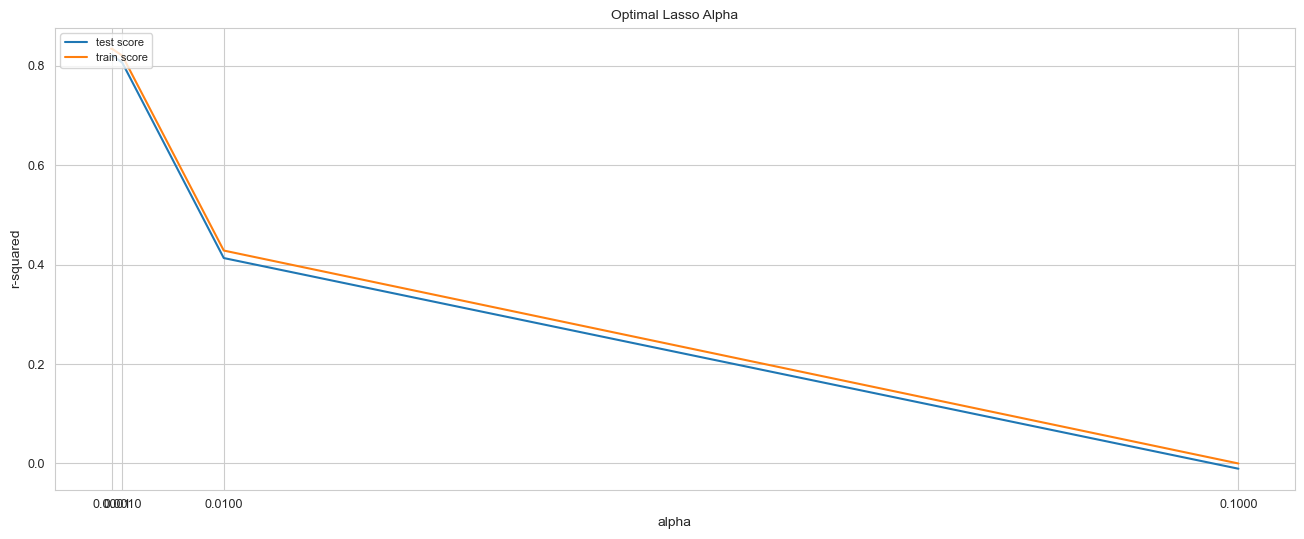

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_alpha"], cv_results["mean_test_score"])
plt.plot(cv_results["param_alpha"], cv_results["mean_train_score"])
plt.xticks(ticks=[0.0001, 0.001, 0.01, 0.1])
plt.xlabel('alpha')
plt.ylabel('r-squared')

plt.title("Optimal Lasso Alpha")
plt.legend(['test score', 'train score'], loc='upper left')

In [169]:
y_preds_train = lasso.predict(X_train)
y_preds_test_lasso = lasso.predict(X_test)

print("R-squared of the model in training set is: {}".format(lasso.score(X_train, y_train)))
print("The optimal value of alpha is: {}".format(lasso.alpha))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_lasso)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_lasso) / y_test)) * 100))

R-squared of the model in training set is: 0.832918625139041
The optimal value of alpha is: 0.0001
-----Test set statistics-----
R-squared of the model in test set is: 0.8427658912528029
Root mean squared error of the prediction is: 0.06467637278099006
Mean absolute percentage error of the prediction is: 10.59974273966807


### Decision Tree Regression  

In [ ]:
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, y_train)
y_pred_DT = DTregressor.predict(X_test)
print("R-squared of the model in training set is: {}".format(DTregressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(DTregressor.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(mse(y_test, y_pred_DT)**(1/2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred_DT) / y_test)) * 100))

R-squared of the model in training set is: 1.0
-----Test set statistics-----
R-squared of the model in test set is: 0.9051020350618086
Root mean squared error of the prediction is: 0.05024591085596309
Mean absolute percentage error of the prediction is: 8.840433280598981


[Text(0.855962712011296, 0.98, 'memberStateCode_UK <= 0.5\nsquared_error = 0.03\nsamples = 695\nvalue = 0.493'),
 Text(0.7490466361438041, 0.94, 'memberStateCode_LV <= 0.5\nsquared_error = 0.019\nsamples = 604\nvalue = 0.451'),
 Text(0.5861885103828464, 0.9, 'barley_price <= 0.446\nsquared_error = 0.016\nsamples = 577\nvalue = 0.463'),
 Text(0.3774294634402056, 0.86, 'memberStateCode_DE <= 0.5\nsquared_error = 0.012\nsamples = 277\nvalue = 0.41'),
 Text(0.3388416108630952, 0.82, 'memberStateCode_FR <= 0.5\nsquared_error = 0.01\nsamples = 256\nvalue = 0.396'),
 Text(0.30105984510281386, 0.78, 'memberStateCode_RO <= 0.5\nsquared_error = 0.009\nsamples = 244\nvalue = 0.387'),
 Text(0.25385129193722944, 0.74, 'memberStateCode_LT <= 0.5\nsquared_error = 0.007\nsamples = 215\nvalue = 0.401'),
 Text(0.22580323322510823, 0.7, 'memberStateCode_HU <= 0.5\nsquared_error = 0.006\nsamples = 172\nvalue = 0.425'),
 Text(0.2087493235930736, 0.66, 'memberStateCode_IE <= 0.5\nsquared_error = 0.004\nsamp

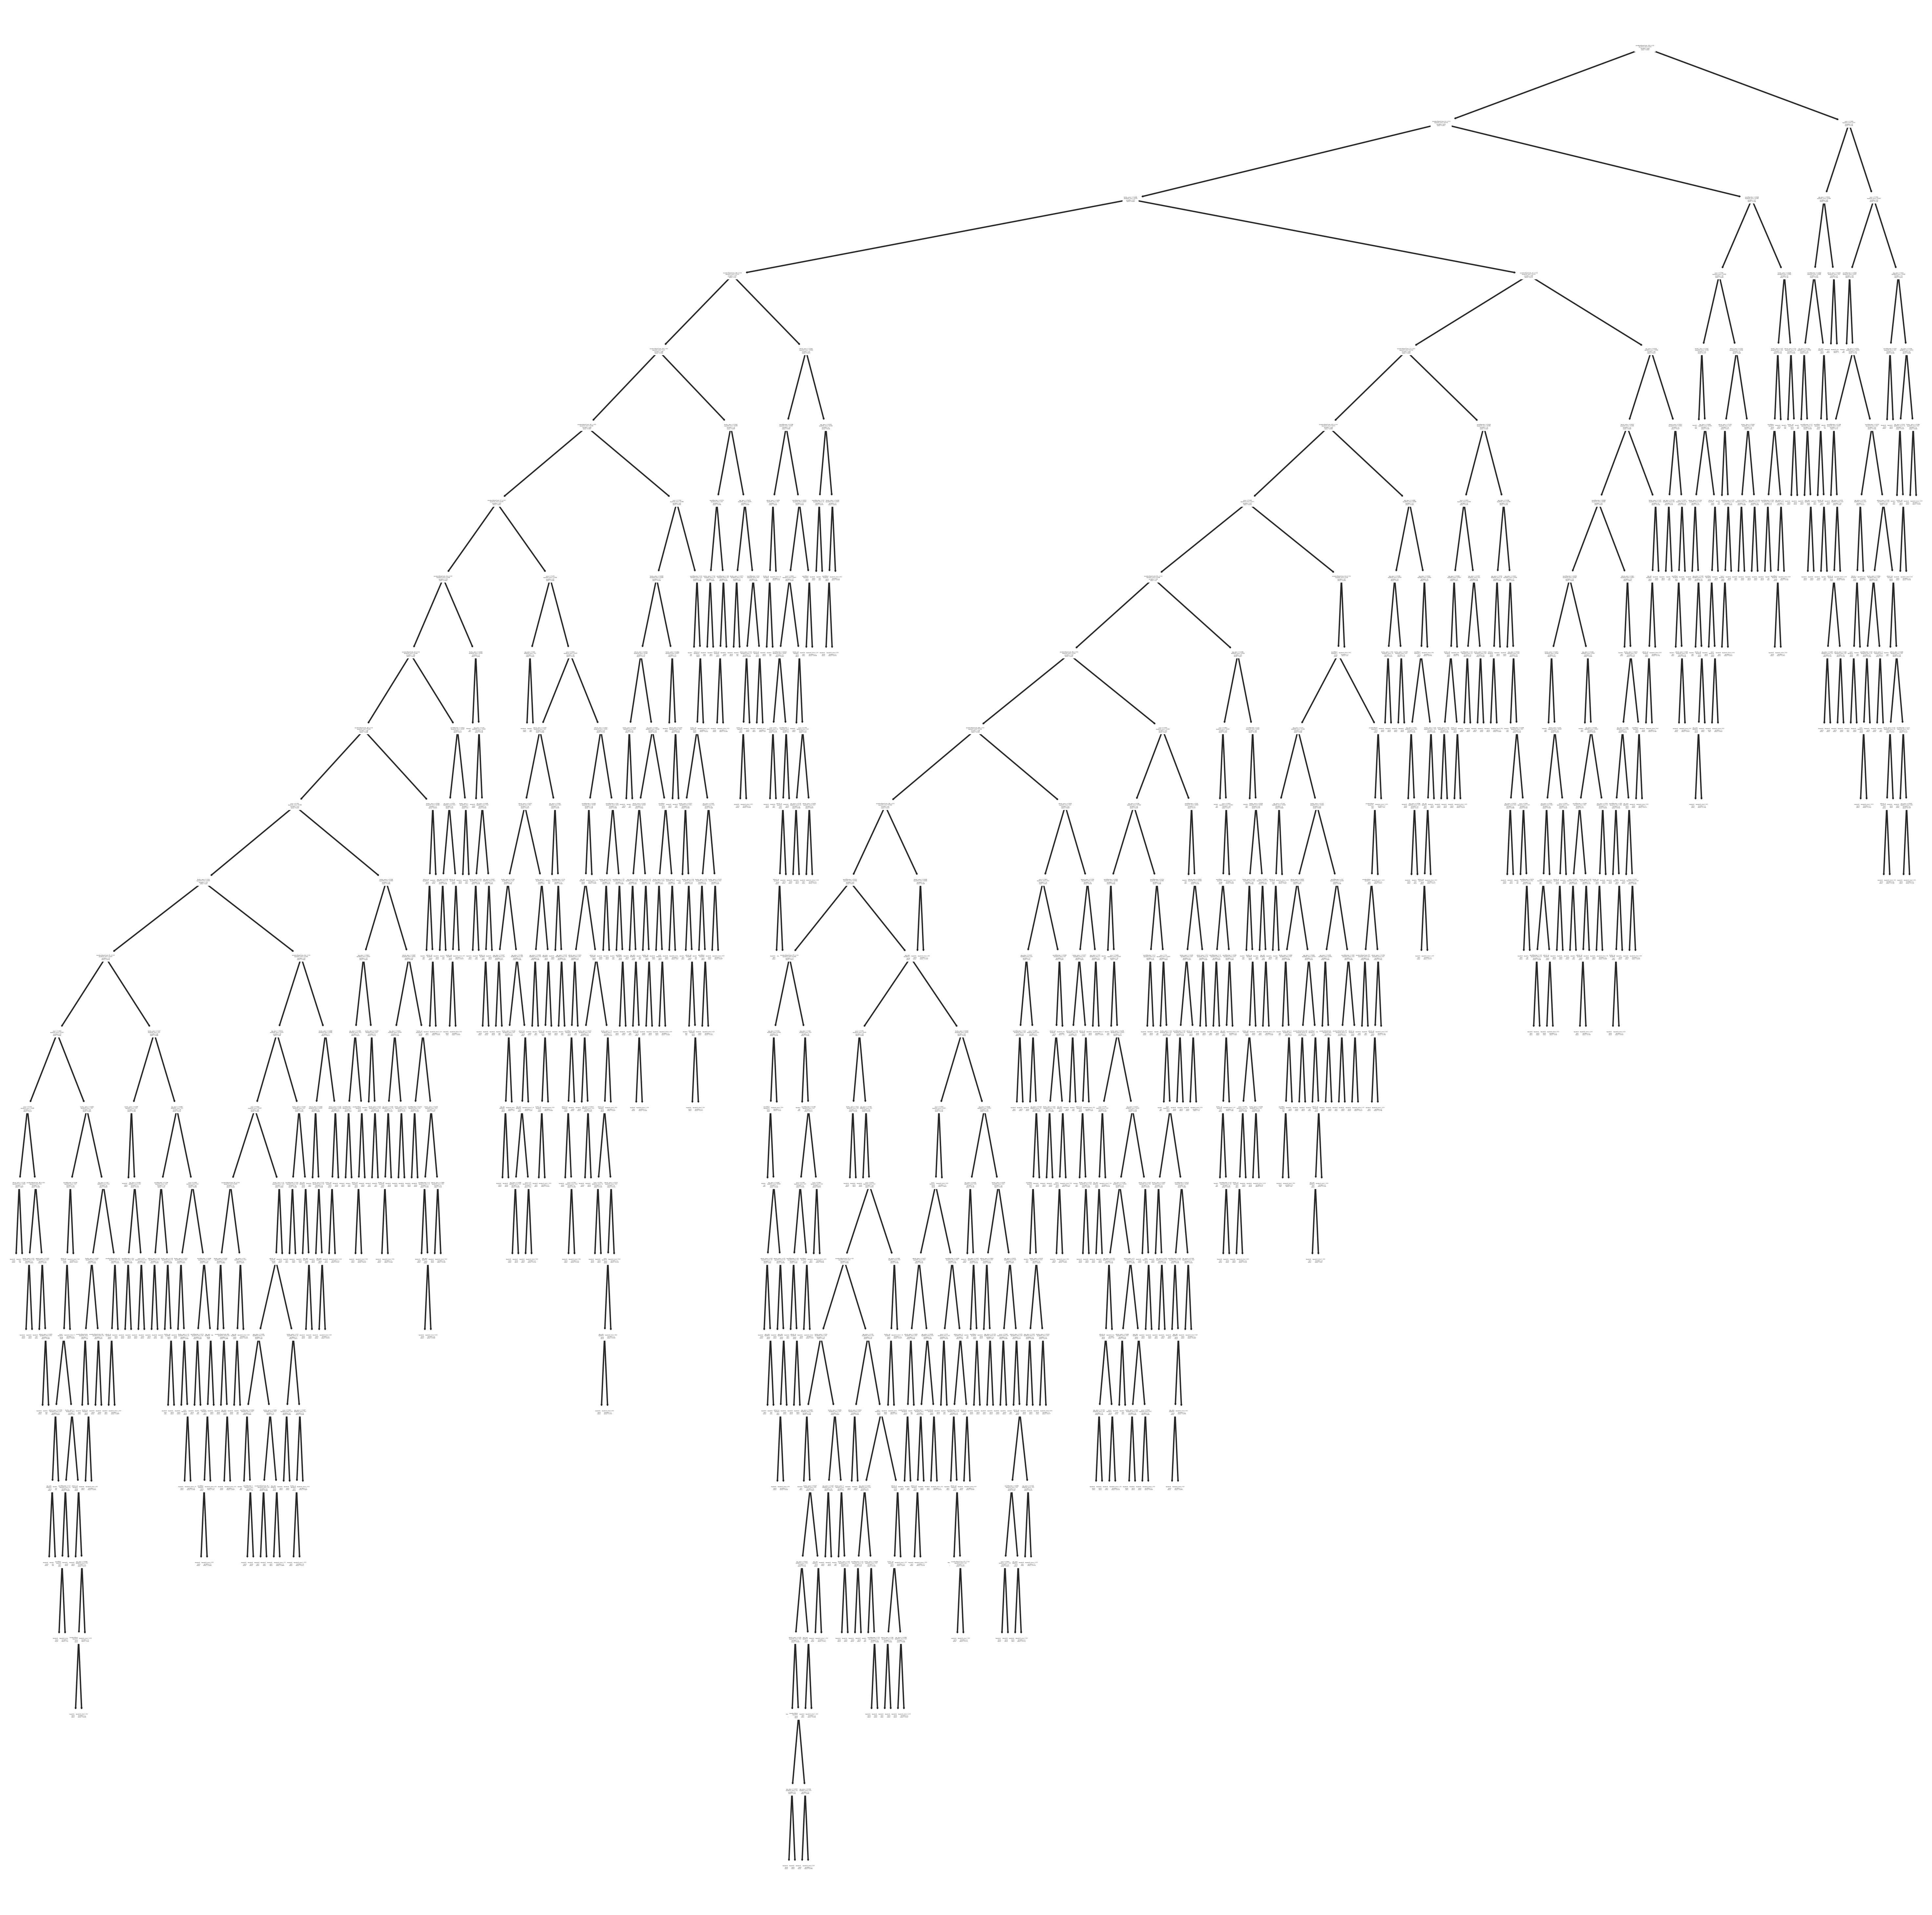

In [171]:
import matplotlib.pyplot as plt
feature_names = X.columns 
cn = ['0','1']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize=(25,25), dpi=300)

tree.plot_tree(DTregressor.fit(X_train, y_train), feature_names=feature_names, class_names=cn ) 

### Random Forest Regression

In [ ]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)
y_pred_random = regressor.predict(X_test)

print("R-squared of the model in training set is: {}".format(regressor.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(regressor.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(mse(y_test, y_pred_random)**(1/2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred_random) / y_test)) * 100))

R-squared of the model in training set is: 0.9910442283028676
-----Test set statistics-----
R-squared of the model in test set is: 0.9531971875022428
Root mean squared error of the prediction is: 0.03528647287009202
Mean absolute percentage error of the prediction is: 6.1872716146825635


### 2.5 Evaluation

A Table or graphics should be provided to illustrate the similarities and contrast of the Machine Learning modelling outcomes based on the scoring metric used for the analysis of the above-mentioned scenario. 

Discuss and elaborate your understanding clearly.
[0 - 15]


## Results

## Conclusion

## Acknowledgements

## References

# Notes:
Additional notes : 
All:
* Your documentation should present your approach to the project, including elements of project planning ( timelines). 
* Ensure that your documentation follows a logical sequence through the planning / research / justification / implementation phases of the project. 
* Ensure that your final upload contains a maximum of 1 jupyter notebook per module.
* Please ensure that additional resources are placed and linked to a logical file structure eg, Scripts, Images, Report, Data etc…
* Ensure that you include your raw and structured datasets in your submission
* 3000(+/- 10%) words in report (not including code, code comments, titles, references or citations) 
* Your Word count MUST be included
